In [1]:
#Import Modules
import uproot
import awkward
import numpy
import matplotlib.pyplot as plt
import matplotlib.figure as figure
import tensorflow as tf
import keras
import keras.layers as layers
from Sum import Sum
from sklearn.model_selection import train_test_split
import pandas as pd
from numpy.lib.recfunctions import structured_to_unstructured
from tensorflow.keras import callbacks
import time
from tensorflow.keras.constraints import max_norm
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, f1_score, r2_score, balanced_accuracy_score, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from scipy.stats import gaussian_kde, pearsonr
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [2]:
#Set hyperparameters
MASKVAL = -999
MAXTRACKS = 32
BATCHSIZE = 64
EPOCHS = 1000
MAXEVENTS = 99999999999999999
# VALFACTOR = 10
LR = 1e-2

In [3]:
# Define Callbacks

# Define Early Stopping
early_stopping = callbacks.EarlyStopping(min_delta=0.001, patience = 20, restore_best_weights = True, monitor = 'val_loss')

#Define ReducedLR
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=10, min_lr=0)


#Define learning schedule

def scheduler(epoch, lr):
  if epoch == (EPOCHS/2):
    return LR
  else:
    return lr

lrscheduler = callbacks.LearningRateScheduler(scheduler)

#Save weights throughout
save_weights = callbacks.ModelCheckpoint('/storage/physics/phuspv/Project/Weights/LongInbox.ckpt', save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)

In [4]:
#Open the root file
tree = uproot.open(r"C:\Users\u2041835\Documents\hffrag.root:CharmAnalysis")

In [5]:
# Decide which branches of the tree we actually want to look at
# Not currently used!
branches = \
  [ \

  # true jet information
   "AnalysisAntiKt4TruthJets_pt"
   , "AnalysisAntiKt4TruthJets_eta"
   , "AnalysisAntiKt4TruthJets_phi"
   , "AnalysisAntiKt4TruthJets_m"


  # true b-hadron information
  # these b-hadrons are inside the truth jets
   , "AnalysisAntiKt4TruthJets_ghostB_pdgId"
    , "AnalysisAntiKt4TruthJets_ghostB_pt"
   , "AnalysisAntiKt4TruthJets_ghostB_eta"
   , "AnalysisAntiKt4TruthJets_ghostB_phi"
   , "AnalysisAntiKt4TruthJets_ghostB_m"
  

  # reconstructed jet information
   , "AnalysisJets_pt_NOSYS"
   , "AnalysisJets_eta"
   , "AnalysisJets_phi"
   , "AnalysisJets_m"


  # reconstructed track information
  , "AnalysisTracks_pt"
  , "AnalysisTracks_eta"
  , "AnalysisTracks_phi"
  , "AnalysisTracks_z0sinTheta"
  , "AnalysisTracks_d0sig"
  , "AnalysisTracks_d0"
  , "AnalysisTracks_d0sigPV"
  , "AnalysisTracks_d0PV"
  ]


  # True jet information
jetfeatures = \
  [ "AnalysisAntiKt4TruthJets_pt"
  , "AnalysisAntiKt4TruthJets_eta"
  , "AnalysisAntiKt4TruthJets_phi"
  , "AnalysisAntiKt4TruthJets_m"
  , "AnalysisAntiKt4TruthJets_ghostB_pt"
  , "AnalysisAntiKt4TruthJets_ghostB_eta"
  , "AnalysisAntiKt4TruthJets_ghostB_phi"
  ,"AnalysisAntiKt4TruthJets_ghostB_m"
  , "AnalysisAntiKt4TruthJets_ghostB_pdgId"
  ]

# true b-hadron information
# these b-hadrons are inside the truth jets
bhadfeatures = \
   [ "AnalysisAntiKt4TruthJets_ghostB_pt"
   , "AnalysisAntiKt4TruthJets_ghostB_eta"
   , "AnalysisAntiKt4TruthJets_ghostB_phi"
   , "AnalysisAntiKt4TruthJets_ghostB_m"
   ]

# reconstructed track information
trackfeatures = ["AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta", "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]

rejetfeatures = ["AnalysisJets_pt_NOSYS" , "AnalysisJets_eta", "AnalysisJets_phi", "AnalysisJets_m"]
  
svertex = ["TruthParticles_Selected_LxyT"]

truthparts = ["TruthParticles_Selected_pdgId"]

elecfeatures = ["AnalysisElectrons_pt_NOSYS", "AnalysisElectrons_eta", "AnalysisElectrons_phi", "AnalysisElectrons_z0sinTheta", "AnalysisElectrons_d0sig", "AnalysisElectrons_d0", "AnalysisElectrons_d0sigPV", "AnalysisElectrons_d0PV", "AnalysisElectrons_charge", "AnalysisElectrons_EOverP", "AnalysisElectrons_firstEgMotherPdgId", "AnalysisElectrons_topoetcone20"]

muonfeatures = ["AnalysisMuons_pt_NOSYS", "AnalysisMuons_eta", "AnalysisMuons_phi", "AnalysisMuons_z0sinTheta", "AnalysisMuons_d0sig", "AnalysisMuons_d0", "AnalysisMuons_d0sigPV", "AnalysisMuons_d0PV", "AnalysisMuons_charge", "AnalysisMuons_is_bad", "AnalysisMuons_topoetcone20", "AnalysisMuons_isIsolated_PflowTight_VarRad_NOSYS"]

In [6]:
# Read in the requested branches from the file
features = tree.arrays(jetfeatures + trackfeatures + elecfeatures + muonfeatures+ rejetfeatures, entry_stop=MAXEVENTS)

In [7]:
#Find where angular distance is small
def matchTracks(jets, trks):
  jeteta = jets["AnalysisAntiKt4TruthJets_eta"] 
  jetphi = jets["AnalysisAntiKt4TruthJets_phi"]

  trketas = trks["AnalysisTracks_eta"]
  trkphis = trks["AnalysisTracks_phi"]

  detas = jeteta - trketas
  dphis = numpy.abs(jetphi - trkphis)

  # deal with delta phis being annoying
  awkward.where(dphis > numpy.pi, dphis - numpy.pi, dphis)

  return numpy.sqrt(dphis**2 + detas**2) < 0.4

def matchElecs(jets, elcs):
  jeteta = jets["AnalysisAntiKt4TruthJets_eta"] 
  jetphi = jets["AnalysisAntiKt4TruthJets_phi"]

  elcetas = elcs["AnalysisElectrons_eta"]
  elcphis = elcs["AnalysisElectrons_phi"]

  detas = jeteta - elcetas
  dphis = numpy.abs(jetphi - elcphis)

  # deal with delta phis being annoying
  awkward.where(dphis > numpy.pi, dphis - numpy.pi, dphis)

  return numpy.sqrt(dphis**2 + detas**2) < 0.4

def matchMuons(jets, mus):
  jeteta = jets["AnalysisAntiKt4TruthJets_eta"] 
  jetphi = jets["AnalysisAntiKt4TruthJets_phi"]

  muetas = mus["AnalysisMuons_eta"]
  muphis = mus["AnalysisMuons_phi"]

  detas = jeteta - muetas
  dphis = numpy.abs(jetphi - muphis)

  # deal with delta phis being annoying
  awkward.where(dphis > numpy.pi, dphis - numpy.pi, dphis)

  return numpy.sqrt(dphis**2 + detas**2) < 0.4

def matchJets(jets, rjs):
  jeteta = jets["AnalysisAntiKt4TruthJets_eta"] 
  jetphi = jets["AnalysisAntiKt4TruthJets_phi"]

  rjetas = rjs["AnalysisJets_eta"]
  rjphis = rjs["AnalysisJets_phi"]

  detas = jeteta - rjetas
  dphis = numpy.abs(jetphi - rjphis)

  # deal with delta phis being annoying
  awkward.where(dphis > numpy.pi, dphis - numpy.pi, dphis)

  return numpy.sqrt(dphis**2 + detas**2) < 0.3

def etaRestrict(jets):
  jeteta = jets[:,:, 1:2]
  return numpy.abs(jeteta)<2.5

In [8]:
#Converting from polar to cartesian

#Used for jets
def ptetaphi2pxpypz(ptetaphi):
  pts = ptetaphi[:,0:1]
  etas = ptetaphi[:,1:2]
  phis = ptetaphi[:,2:3]

  pxs = pts * numpy.cos(phis)
  pys = pts * numpy.sin(phis)
  pzs = pts * numpy.sinh(etas)

  isinf = numpy.isinf(pzs)

  if numpy.any(isinf):
    print("inf from eta:")
    print(etas[isinf])
    raise ValueError("infinity from sinh(eta)")

  return numpy.concatenate([pxs, pys, pzs], axis=1)

#Used for tracks
def ptetaphi2pxpypz2(ptetaphi):
  pts = ptetaphi[:,:,0:1]
  etas = ptetaphi[:,:,1:2]
  phis = ptetaphi[:,:,2:3]

  mask = pts == MASKVAL
  #Looking in array and testing a condition - if finds mask, replaces mask with pt value
  pxs = numpy.where(mask, pts, pts * numpy.cos(phis)) # Apply transformation only to actual pT
  pys = numpy.where(mask, pts, pts * numpy.sin(phis))
  pzs = numpy.where(mask, pts, pts * numpy.sinh(etas))

  isinf = numpy.isinf(pzs)

  if numpy.any(isinf):
    print("inf from eta:")
    print(etas[isinf])
    raise ValueError("infinity from sinh(eta)")

  return numpy.concatenate([pxs, pys, pzs], axis=2)

def ptetaphi2pxpypz3(ptetaphi):
  pts = ptetaphi[:,:,0:1]
  etas = ptetaphi[:,:,1:2]
  phis = ptetaphi[:,:,2:3]

  mask = pts == MASKVAL
  #Looking in array and testing a condition - if finds mask, replaces mask with pt value
  pxs = numpy.where(mask, pts, pts * numpy.cos(phis)) # Apply transformation only to actual pT
  pys = numpy.where(mask, pts, pts * numpy.sin(phis))
  pzs = numpy.where(mask, pts, pts * numpy.sinh(etas))

  isinf = numpy.isinf(pzs)

  if numpy.ma.any(isinf):
    print("inf from eta:")
    print(etas[isinf])
    raise ValueError("infinity from sinh(eta)")

  return numpy.concatenate([pxs, pys, pzs], axis=2)

In [9]:
# Pads inputs with nans up to the given maxsize
def pad(xs, maxsize):
  #Find 'none' values in array and replace with MASKVAL (= fill_none)
  ys = \
    awkward.fill_none \
  ( awkward.pad_none(xs, maxsize, axis=1, clip=True) #Adding 'none' values to make sure it is correct size
  , MASKVAL
  )[:,:maxsize]

  return awkward.to_regular(ys, axis=1)

In [10]:
def flatten1(xs, maxsize=-1):
  ys = {}
  for field in xs.fields:
    zs = xs[field]
    if maxsize > 0:
      zs = pad(zs, maxsize)
    ys[field] = zs

  return awkward.zip(ys)

In [11]:
#Define histogram plotting functions
# returns a fixed set of bin edges
def fixedbinning(xmin, xmax, nbins):
  return numpy.mgrid[xmin:xmax:nbins*1j]


# define two functions to aid in plotting
def hist(xs, binning, normalized=False):
  ys = numpy.histogram(xs, bins=binning)[0]

  yerrs = numpy.sqrt(ys)

  if normalized:
    s = numpy.sum(ys)
    ys = ys / s
    yerrs = yerrs / s

  return ys, yerrs


def binneddensitysub(xs, binning, ax, label=None, xlabel=None, ylabel="binned probability density"):
  #fig = figure.Figure(figsize=(8, 8))
  #plt = fig.add_subplot(111)

  ys , yerrs = hist(xs, binning, normalized=True)

  # determine the central value of each histogram bin
  # as well as the width of each bin
  # this assumes a fixed bin size.
  xs = (binning[1:]+binning[:-1]) / 2.0
  xerrs = ((binning[1:]-binning[:-1]) / 2.0)

  ax.errorbar \
    ( xs
    , ys
    , xerr=xerrs
    , yerr=yerrs
    , label=label
    , linewidth=0
    , elinewidth=2
    , marker = 'None'
    )

  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  #return fig

def binneddensity(xs, binning, label=None, xlabel=None, ylabel="binned probability density"):
  fig = figure.Figure(figsize=(8, 8))
  plt = fig.add_subplot(111)

  ys , yerrs = hist(xs, binning, normalized=True)

  # determine the central value of each histogram bin
  # as well as the width of each bin
  # this assumes a fixed bin size.
  xs = (binning[1:]+binning[:-1]) / 2.0
  xerrs = ((binning[1:]-binning[:-1]) / 2.0)

  plt.errorbar \
    ( xs
    , ys
    , xerr=xerrs
    , yerr=yerrs
    , label=label
    , linewidth=0
    , elinewidth=2
    )

  plt.set_xlabel(xlabel)
  plt.set_ylabel(ylabel)

  return fig

In [12]:
# Select the events of interest
goodjets = \
  numpy.logical_and \
    ( numpy.abs(features["AnalysisAntiKt4TruthJets_eta"]) < 2.5
    , features["AnalysisAntiKt4TruthJets_pt"] > 25000
    )

events = features[(awkward.sum(goodjets, axis=1) > 0)]


jets1 = events[jetfeatures][:,0] #First jet
tracks = events[trackfeatures]
electrons = events[elecfeatures]
muons = events[muonfeatures]

In [13]:
matchedtracks = tracks[matchTracks(jets1, tracks)] 
matchedtracks = flatten1(matchedtracks, MAXTRACKS) #Turn into regular np array

In [14]:
bjets = awkward.sum(jets1["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0 #Find b hadron jets with certain momentum
jets2 = jets1[bjets] #Jets identified as b jets are only jets considered
bhadspt= jets2["AnalysisAntiKt4TruthJets_ghostB_pt"][:,0] #np Stack here - Each sub array contains all the features of the jet (axis -1)
bhadseta = jets2["AnalysisAntiKt4TruthJets_ghostB_eta"][:, 0]
bhadsphi = jets2["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0]
bmass = jets2["AnalysisAntiKt4TruthJets_ghostB_m"][:,0].to_numpy()
truthbhadronsid = events["AnalysisAntiKt4TruthJets_ghostB_pdgId"]
bhadid = jets2["AnalysisAntiKt4TruthJets_ghostB_pdgId"][:,0].to_numpy()
matchedtracks = matchedtracks[bjets]

In [15]:
rejets = events[rejetfeatures]
matchedjets = rejets[matchJets(jets1, rejets)]
matchedjets = matchedjets[bjets]
matchedjets = flatten1(matchedjets, MAXTRACKS)[:,0]
matchedjets = structured_to_unstructured(matchedjets).to_numpy()

In [16]:
numpy.shape(matchedjets)

(67961, 4)

In [17]:
jets3 = structured_to_unstructured(jets2[jetfeatures[:3]]) #number of features
matchedtracks = structured_to_unstructured(matchedtracks)
matchedtracks = matchedtracks.to_numpy()

In [18]:
#matchedelectrons = electrons[matchElecs(jets1, electrons)]
matchedelectrons = flatten1(electrons, MAXTRACKS)
#matchedmuons = muons[matchMuons(jets1, muons)]
matchedmuons = flatten1(muons, MAXTRACKS)
matchedelectrons = matchedelectrons[bjets]
matchedmuons = matchedmuons[bjets]
matchedelectrons = structured_to_unstructured(matchedelectrons).to_numpy()
matchedmuons = structured_to_unstructured(matchedmuons).to_numpy()
electrons = ptetaphi2pxpypz2(matchedelectrons)
muons = ptetaphi2pxpypz2(matchedmuons)
electrons = numpy.concatenate([electrons, matchedelectrons], axis=-1)
muons = numpy.concatenate([muons, matchedmuons], axis=-1)

C:\Users\u2041835\AppData\Local\Temp\ipykernel_17196\1564012438.py:32: RuntimeWarning: overflow encountered in sinh
  pzs = numpy.where(mask, pts, pts * numpy.sinh(etas))


In [19]:
print(numpy.shape(matchedmuons))

(67961, 32, 12)


In [20]:
#If can't find charges
unique_id, idcounts = numpy.unique(bhadid, return_counts=True)
print(numpy.stack([unique_id, idcounts], axis = -1 ))
other = awkward.from_numpy(numpy.array([-5332,-5232,-5132, -5122, -541, 541, 553, 5122, 5132, 5232, 5332]))
classTargets = numpy.zeros(len(bhadid))
for x in range(len(bhadid)):
    if bhadid[x] in other:
        classTargets[x] = 0
    elif numpy.abs(bhadid[x]) == 531:
        classTargets[x] = 1
    elif numpy.abs(bhadid[x]) == 521:
        classTargets[x] = 2
    elif numpy.abs(bhadid[x]) == 511:
        classTargets[x] = 3
    else:
        classTargets[x] = bhadid[x]
        print([x])

classTargets = classTargets.astype(int)


[[-5332     3]
 [-5232   194]
 [-5132   194]
 [-5122  1356]
 [ -541     1]
 [ -531  3230]
 [ -521 14529]
 [ -511 14380]
 [  511 14462]
 [  521 14740]
 [  531  3194]
 [  541     2]
 [  553     1]
 [ 5122  1317]
 [ 5132   177]
 [ 5232   177]
 [ 5332     4]]


In [21]:
__, counts = numpy.unique(classTargets, return_counts=True)
print(counts/numpy.sum(counts))

[0.05041127 0.0945248  0.43067347 0.42439046]


In [22]:
agh, counts = numpy.unique(bmass, return_counts=True)
hi = counts*100/numpy.sum(counts)
hi_float = [float('{:.2f}'.format(i)) for i in hi]
print(hi_float)
numpy.set_printoptions(precision=2, suppress=True)
hi_float2 = [float('{:.2f}'.format(i)) for i in agh]
hi_float3 = [float('{:.2f}'.format(i)) for i in counts]
print(numpy.stack([hi_float2, hi_float3, hi_float], axis=-1))

[29.53, 13.53, 42.44, 9.45, 2.45, 1.48, 0.45, 0.18, 0.46, 0.01, 0.0, 0.0]
[[ 5279.17 20071.      29.53]
 [ 5279.25  9198.      13.53]
 [ 5279.58 28842.      42.44]
 [ 5366.77  6424.       9.45]
 [ 5619.4   1665.       2.45]
 [ 5620.2   1008.       1.48]
 [ 5788.     309.       0.45]
 [ 5790.5    123.       0.18]
 [ 5791.1    310.       0.46]
 [ 6070.       7.       0.01]
 [ 6277.       3.       0.  ]
 [ 9460.29     1.       0.  ]]


In [23]:
idindices = numpy.searchsorted(numpy.unique(classTargets), classTargets)

In [24]:
#If can find charges
'''unique_id, idcounts = numpy.unique(bhadid, return_counts=True)
print(numpy.stack([unique_id, idcounts], axis = -1 ))
other = awkward.from_numpy(numpy.array([-5332,-5232,-5132, -5122, -541, 541, 553, 5122, 5132, 5232, 5332]))
classTargets = numpy.zeros(len(bhadid))
for x in range(len(bhadid)):
    if bhadid[x] in other:
        classTargets[x] = 0
    else:
        classTargets[x] = bhadid[x]

classTargets = classTargets.astype(int)'''


'unique_id, idcounts = numpy.unique(bhadid, return_counts=True)\nprint(numpy.stack([unique_id, idcounts], axis = -1 ))\nother = awkward.from_numpy(numpy.array([-5332,-5232,-5132, -5122, -541, 541, 553, 5122, 5132, 5232, 5332]))\nclassTargets = numpy.zeros(len(bhadid))\nfor x in range(len(bhadid)):\n    if bhadid[x] in other:\n        classTargets[x] = 0\n    else:\n        classTargets[x] = bhadid[x]\n\nclassTargets = classTargets.astype(int)'

In [25]:
jets4 = ptetaphi2pxpypz(jets3).to_numpy()
tracks = ptetaphi2pxpypz2(matchedtracks)
tracks = numpy.concatenate([tracks, matchedtracks[:,:,3:]], axis = 2)
bhadspt = bhadspt.to_numpy()
bhadseta = bhadseta.to_numpy()
bhads = numpy.stack([bhadspt, bhadseta], axis=-1)
bhads2 = numpy.stack([bhadspt, bhadseta, bhadsphi], axis=-1)
bhadscart = ptetaphi2pxpypz(bhads2).to_numpy()

jetpT = jets3[:,0]
jetEta = jets3[:,1]
jetphi = jets3[:,2]
jets5 = numpy.stack([jetpT, jetEta, jetphi], axis = -1).to_numpy()

C:\Users\u2041835\AppData\Local\Temp\ipykernel_17196\1564012438.py:32: RuntimeWarning: overflow encountered in sinh
  pzs = numpy.where(mask, pts, pts * numpy.sinh(etas))


In [26]:
bhadspx = bhadscart[:,0] 
bhadspy = bhadscart[:,1]
bhadspz = bhadscart[:,2]
bhadsmom = numpy.sqrt((bhadspx**2+bhadspy**2+bhadspz**2))
bhadenergy = numpy.sqrt(bhadsmom**2+bmass**2)
truejetpx = jets4[:,0]
truejetpy = jets4[:,1]
truejetpz = jets4[:,2]
truejetpT = jets5[:,0]
truejeteta = jets5[:,1]
truejetmass = jets2["AnalysisAntiKt4TruthJets_m"].to_numpy()
truejetmom = numpy.sqrt(numpy.square(truejetpz) +numpy.square(truejetpz) + numpy.square(truejetpz))
truejetenergy = numpy.sqrt(numpy.square(truejetmom)+numpy.square(truejetmass))
truejetmomfraction = truejetpT / truejetenergy
truejet_transversemass = numpy.sqrt(numpy.square(truejetenergy) - numpy.square(truejetpz))
truejetfeatures = numpy.stack([truejetpx, truejetpy, truejetpz, truejetpT, truejeteta, truejetmass, truejetenergy, truejetmomfraction, truejetmom, truejet_transversemass], axis = -1)
bmomfraction = bhadspt/truejetpT
bdotproduct = numpy.sum(bhadscart*jets4, axis=1)
bcrossproduct = numpy.cross(bhadscart, jets4, axisa=1, axisb=1)
jetnorm = numpy.linalg.norm(jets4, axis=1)
blongmom = bdotproduct/(jetnorm**2)
btransmom = numpy.linalg.norm(bcrossproduct)/(jetnorm**2)
btransmass = numpy.sqrt(numpy.square(bmass)+numpy.square(bhadspt))
bfeatures = numpy.stack([bhadspx, bhadspy, bhadspz, bhadspt, bhadenergy, btransmass, bmomfraction, blongmom, btransmom], axis = -1)

In [27]:
matchedjets = numpy.ma.masked_values(matchedjets,-999)
rejetscart = ptetaphi2pxpypz(matchedjets)
rejetscart = numpy.ma.masked_values(rejetscart, -999)

C:\Users\u2041835\AppData\Local\Temp\ipykernel_17196\1564012438.py:11: RuntimeWarning: overflow encountered in sinh
  pzs = pts * numpy.sinh(etas)


In [28]:
print(numpy.shape(rejetscart))

(67961, 3)


In [29]:
rejetscart = numpy.ma.masked_values(rejetscart, -999)

In [30]:
#["AnalysisJets_pt_NOSYS" , "AnalysisJets_eta", "AnalysisJets_phi", "AnalysisJets_m"]
rejets = events[rejetfeatures]
rejets = rejets[bjets]
rejets = flatten1(rejets, MAXTRACKS)[:,0].to_numpy()
rejets = structured_to_unstructured(rejets)
rejets = numpy.ma.masked_values(rejets, -999)
rejets = numpy.ma.masked_values(rejets, -999.)
print((rejets))
reconjetcart = ptetaphi2pxpypz(rejets[:,:3])
print(numpy.shape(reconjetcart))
reconjetpx = reconjetcart[:,0]
reconjetpy = reconjetcart[:,1]
reconjetpz = reconjetcart[:,2]
reconjetpT = rejets[:,0]
reconjeteta = rejets[:,1]
reconjetphi = rejets[:,2]
reconjetmass = rejets[:,3]
reconjetmom = (numpy.linalg.norm(rejets[:,:3], axis = 1))
reconjetenergy = numpy.ma.sqrt(numpy.square(reconjetmom) + numpy.square(reconjetmass))
reconjetmomfraction = reconjetpT / reconjetenergy
reconjet_transversemass = numpy.ma.sqrt(numpy.square(reconjetenergy) - numpy.square(reconjetpz))
reconjetfeatures = numpy.ma.stack([reconjetpx, reconjetpy, reconjetpz, reconjetpT, reconjeteta, reconjetmass, reconjetenergy, reconjetmomfraction, reconjetmom, reconjet_transversemass], axis=-1)
print(numpy.min(reconjetmass))

[[166917.34375 0.2306067794561386 -2.160438299179077 24445.865234375]
 [121782.15625 1.6290850639343262 1.6494553089141846 22202.916015625]
 [118449.625 -2.4087936878204346 -2.4663634300231934 8503.6884765625]
 [55606.765625 0.16095179319381714 -0.9589057564735413 13486.33984375]
 [45025.5546875 -0.6617171764373779 -0.9280535578727722 7880.68212890625]
 [108554.0859375 -0.3403359055519104 -1.368058681488037 14639.06640625]
 [91970.421875 2.072009563446045 0.7445970177650452 10107.82421875]
 [105513.03125 -1.344000220298767 -2.384953022003174 9912.837890625]
 [72939.3828125 0.3608759641647339 -0.2818695604801178 10675.248046875]
 [156447.53125 0.43834471702575684 2.120122194290161 8720.9619140625]
 [109840.625 -0.6720136404037476 0.5829148292541504 19570.21484375]
 [165064.53125 0.9117904305458069 -1.6365396976470947 17690.50390625]
 [225546.28125 -2.403459072113037 -0.42800742387771606 27032.39453125]
 [84242.4765625 0.35924437642097473 1.7683179378509521 14740.3330078125]
 [141647.640

C:\Users\u2041835\AppData\Local\Temp\ipykernel_17196\1564012438.py:11: RuntimeWarning: overflow encountered in sinh
  pzs = pts * numpy.sinh(etas)


In [31]:
maskedtracks = numpy.ma.masked_values(matchedtracks, -999)
#maskedetas = numpy.ma.masked_values(detas,-999)
#maskedphis = numpy.ma.masked_values(dphis,-999)
#TrackWidthEtaNum = numpy.sum(maskedtracks[:,:,0] * numpy.square(maskedetas),axis=1)
#TrackWidthEtaDen = numpy.sum(matchedtracks[:,:,0], axis=1)
#TrackWidthEta = numpy.sqrt(TrackWidthEtaNum, TrackWidthEtaDen)
#TrackWidthPhi = numpy.sqrt(numpy.divide(numpy.sum(maskedtracks[:,:,0] * numpy.square(maskedphis)), numpy.sum(maskedtracks[:,:,0], axis=1)))
trackfeatures = ["AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta", "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]
vertSignificance = numpy.divide(numpy.sum(numpy.divide(numpy.square(maskedtracks[:,:,4]), maskedtracks[:,:,5]), axis=1), numpy.sqrt(numpy.sum(numpy.divide(numpy.square(maskedtracks[:,:,4]), numpy.square(maskedtracks[:,:,5])),axis = 1)))
tracketafrac = numpy.where(matchedtracks[:,:,0]!=-999, numpy.divide(matchedtracks[:,:,1], truejeteta[:, numpy.newaxis]), -999)
trackproj = numpy.where(matchedtracks[:,:,0]!=-999, numpy.sum(tracks[:,:,:3]*jets4[:,numpy.newaxis,:3], axis=2),-999)
scaledtrackproj = numpy.where(trackproj!=-999, trackproj/jetnorm[:,numpy.newaxis],-999)
crazyTrackFeatures= numpy.stack([trackproj, tracketafrac, scaledtrackproj], axis=-1)
#crazyJetFetures = numpy.stack([TrackWidthEta, TrackWidthPhi, vertSignificance], axis=-1)

C:\Users\u2041835\AppData\Local\Temp\ipykernel_17196\2272289968.py:9: RuntimeWarning: invalid value encountered in true_divide
  vertSignificance = numpy.divide(numpy.sum(numpy.divide(numpy.square(maskedtracks[:,:,4]), maskedtracks[:,:,5]), axis=1), numpy.sqrt(numpy.sum(numpy.divide(numpy.square(maskedtracks[:,:,4]), numpy.square(maskedtracks[:,:,5])),axis = 1)))


In [32]:
#Stack using numpy.where, mask using numpy.ma, normalise, input
inputs1 = numpy.concatenate([tracks[:,:,:3], matchedtracks], axis = 2)
trackpx = tracks[:,:,0]
trackpy = tracks[:,:,1]
trackpz = tracks[:,:,2]
trackp = numpy.where(trackpx!=-999, numpy.sqrt(numpy.square(trackpx) + numpy.square(trackpy) + numpy.square(trackpz)), -999)

trackpfrac = numpy.zeros(shape=numpy.shape(trackp))
#trackpxfrac = numpy.where(trackp!=-999, numpy.divide(inputs1[:,:,0], truejetfeatures[:,0, numpy.newaxis]), -999)
#trackpyfrac = numpy.where(trackp!=-999, numpy.divide(inputs1[:,:,1], truejetfeatures[:,1, numpy.newaxis]), -999)
trackpzfrac = numpy.where(trackp!=-999, numpy.divide(inputs1[:,:,2], truejetfeatures[:,2, numpy.newaxis]), -999)
trackptfrac = numpy.where(trackp!=-999, numpy.divide(inputs1[:,:,3], truejetfeatures[:,3, numpy.newaxis]), -999)
trackpfrac = numpy.where(trackp!=-999, numpy.divide(trackp, truejetmom[:,numpy.newaxis]),-999)
#trackpfrac = numpy.stack([trackptfrac, trackpfrac], axis = -1)
logtrackpfrac = numpy.where(trackptfrac!=-999, numpy.ma.log(trackptfrac), -999)

detas = numpy.where(matchedtracks[:,:,1]!=-999, numpy.subtract(jetEta[:, numpy.newaxis], matchedtracks[:,:,1]), -999)
dphis = numpy.where(matchedtracks[:,:,1]!=-999, numpy.abs(numpy.subtract(jetphi[:, numpy.newaxis], matchedtracks[:,:,2])), -999)
awkward.where(dphis > numpy.pi, dphis - numpy.pi, dphis)

deltaR = numpy.where(dphis!= -999, numpy.sqrt(dphis**2 + detas**2), -999)
logdeltaR = numpy.where(deltaR!= - 999, numpy.log(deltaR), -999)

unmasked_inputs = numpy.concatenate([inputs1, logtrackpfrac[:,:,numpy.newaxis]], axis = -1)
unmasked_inputs = numpy.concatenate([unmasked_inputs, deltaR[:,:, numpy.newaxis]], axis = -1)
unmasked_inputs = numpy.concatenate([unmasked_inputs, logdeltaR[:,:, numpy.newaxis]], axis = -1)
#unmasked_inputs = numpy.concatenate([unmasked_inputs, matchedelectrons], axis = -1)
#unmasked_inputs = numpy.concatenate([unmasked_inputs, matchedmuons], axis = -1)
print(numpy.shape(scaledtrackproj))
unmasked_inputs = numpy.concatenate([unmasked_inputs, scaledtrackproj[:,:,numpy.newaxis]], axis = -1)
unmasked_inputs = numpy.concatenate([unmasked_inputs, electrons], axis = 1)
unmasked_inputs = numpy.concatenate([unmasked_inputs, muons], axis = 1)

masked_inputs = numpy.ma.masked_values(unmasked_inputs, -999)
def scalert(array):
    scaled = numpy.zeros(shape = numpy.shape(array))
    for i in range(array.shape[-1]):
        scaled[:,:,i] = (array[:,:,i] - numpy.mean(array[:,:,i]))/numpy.std(array[:,:,i])
    return scaled

def scalerj(array):
    scaled = numpy.ma.zeros(shape = numpy.shape(array))
    for i in range(array.shape[-1]):
        scaled[:,i] = (array[:,i] - numpy.ma.mean(array[:,i]))/numpy.ma.std(array[:,i])
    return scaled

def scalerb(array):
    scaled = numpy.zeros(shape = numpy.shape(array))
    scaled = (array - numpy.mean(array))/numpy.std(array)
    return scaled

def unscaler(array, fac):
    unscaled = array*numpy.std(fac) + numpy.mean(fac)
    return unscaled

trackinputs = scalert(masked_inputs)
jetinputs = scalerj(truejetfeatures)

jetTargets = numpy.stack([truejetpx*10**-6, truejetpy*10**-6, truejetpz*10**-6, truejetpT*10**-6, truejeteta, truejetmass*10**-6, truejetenergy*10**-6, truejetmomfraction, truejetmom*10**-6, truejet_transversemass*10**-6], axis = -1)

targets = numpy.concatenate([bfeatures, jetTargets], axis=-1)

TargetShape = (len(numpy.shape(targets)))
if TargetShape == 1:
    numtargets = 1
else:
    numtargets = len(targets[-1])



numtargetsClass = 4

#Tracks = px, py, pz, pT, eta, phi, 5* IP, logTrack/Jet
#Sum Tracks = sum px, sum py, sum pz, sum pT, sqrt sum px^2, sqrt sum py^2, sqrt sum pz^2, sqrt sum pT^2, sqrt sum px^2/ sum px, sqrt sum py^2 / sum py, sqrt sum pz^2 / sum pz, sqrt sum pT^2 / sum pT,
#jets = px, py, pz, pT, eta, mass, energy, mom/energy, mom
#Bhads = px, py, pz, pT, Eta, Mass

c:\Users\u2041835\Anaconda3\lib\site-packages\awkward\_backends.py:58: RuntimeWarning: invalid value encountered in log
  return getattr(ufunc, method)(*args, **kwargs)


(67961, 32)


In [33]:
masked_tracks = numpy.ma.masked_values(inputs1[:,:,:4], -999)
sumtracks = numpy.ma.sum(masked_tracks, axis = 1)

sum_square_tracks = numpy.ma.sqrt(numpy.ma.sum(numpy.square(masked_tracks), axis = 1))
scaled_sum_square_tracks = sum_square_tracks/sumtracks


inputs2 = numpy.ma.concatenate([sumtracks, scaled_sum_square_tracks, sum_square_tracks], axis = 1)
summed_inputs = scalerj(inputs2)
jetinputs = numpy.concatenate([summed_inputs, jetinputs], axis=-1)
print(numpy.min((summed_inputs)))

testing = numpy.where(inputs2==None, -9999999999999, inputs2)
print(numpy.min(testing))

-258.0050248970036
-78476452.56477481


In [34]:
print("Track Input Shape = ", str(numpy.shape(trackinputs)))
print("Jet Input Shape = ", str(numpy.shape(jetinputs)))
print("Summed Input Shape = ", str(numpy.shape(summed_inputs)))

Track Input Shape =  (67961, 96, 15)
Jet Input Shape =  (67961, 22)
Summed Input Shape =  (67961, 12)


In [35]:
#Define MC Dropout
class MCDropout(keras.layers.GaussianDropout):
	def call(self, inputs):
		return super().call(inputs, training = None)

In [36]:
tracklayers = [256 , 128, 64, 32 ]
jetlayers = [ 32, 64 , 128, 256 ]

def buildModel(tlayers, jlayers, ntargets, ntargetsclass):

  inputs = layers.Input(shape=(None, tlayers[0]))
  inputs2 = layers.Input(shape = ( len(jetinputs[-1],)))

  outputs = inputs
  outputs = layers.Masking(mask_value=MASKVAL)(outputs)
  #outputs = (layers.GaussianNoise(1))(outputs)

  
  outputs2 = inputs2
  #outputs2 = layers.GaussianNoise(0.5)(outputs2)

  
  outputs = layers.TimeDistributed(layers.Dropout(0.3))(outputs)
  outputs = layers.TimeDistributed(layers.Dense(64, activation='gelu', kernel_initializer = 'he_normal', kernel_constraint = max_norm(1.), kernel_regularizer='l1_l2'))(outputs)
  outputsa = layers.TimeDistributed(layers.GroupNormalization(groups = 16))(outputs)

  outputs = layers.TimeDistributed(layers.Dropout(0.3))(outputsa)
  outputs = layers.TimeDistributed(layers.Dense(64, activation='gelu', kernel_initializer = 'he_normal', kernel_constraint = max_norm(1.), kernel_regularizer='l1_l2'))(outputs)
  outputsb = layers.TimeDistributed(layers.GroupNormalization(groups = 16))(outputs)

  outputs = layers.Add()([outputsa, outputsb])

  outputs = layers.TimeDistributed(layers.Dropout(0.3))(outputs)
  outputs = layers.TimeDistributed(layers.Dense(64, activation='gelu', kernel_initializer = 'he_normal', kernel_constraint = max_norm(1.), kernel_regularizer='l1_l2'))(outputs)
  outputsc = layers.TimeDistributed(layers.GroupNormalization(groups=16))(outputs)

  outputs = layers.Add()([outputsa, outputsb, outputsc])

  outputs = layers.TimeDistributed(layers.Dropout(0.3))(outputs)
  outputs = layers.TimeDistributed(layers.Dense(64, activation='gelu', kernel_initializer = 'he_normal', kernel_constraint = max_norm(1.), kernel_regularizer='l1_l2'))(outputs)
  outputsd = layers.TimeDistributed(layers.GroupNormalization(groups=16))(outputs)

  outputs = layers.Add()([outputsa, outputsb, outputsc, outputsd])

  outputs = layers.TimeDistributed(layers.Dense(tlayers[-1], activation='softmax'))(outputs)
  outputs = Sum()(outputs)


  outputs = keras.layers.Concatenate()([outputs, outputs2])

  outputs = layers.Dropout(0.3)(outputs)
  outputs = layers.Dense(128, activation='gelu', kernel_initializer='he_normal', kernel_constraint = max_norm(1.), kernel_regularizer='l1_l2')(outputs)#, kernel_regularizer='l1_l2' 
  outputsa = layers.GroupNormalization(groups=16)(outputs)

  outputs = layers.Dropout(0.3)(outputsa)
  outputs = layers.Dense(128, activation='gelu', kernel_initializer='he_normal', kernel_constraint = max_norm(1.), kernel_regularizer='l1_l2')(outputsa)#, kernel_regularizer='l1_l2' 
  outputsb = layers.GroupNormalization(groups=16)(outputs)

  outputs = layers.Add()([outputsa, outputsb])

  outputs = layers.Dropout(0.3)(outputs)
  outputs = layers.Dense(128, activation='gelu', kernel_initializer='he_normal', kernel_constraint = max_norm(1.), kernel_regularizer='l1_l2')(outputs)#, kernel_regularizer='l1_l2' 
  outputsc = layers.GroupNormalization(groups=16)(outputs)

  outputs = layers.Add()([outputsa, outputsb, outputsc])

  outputs = layers.Dropout(0.3)(outputs)
  outputs = layers.Dense(128, activation='gelu', kernel_initializer='he_normal', kernel_constraint = max_norm(1.), kernel_regularizer='l1_l2')(outputs)#, kernel_regularizer='l1_l2' 
  outputsd = layers.GroupNormalization()(outputs)

  outputs = layers.Add()([outputsa, outputsb, outputsc, outputsd])

  #outputsReg  = layers.Dense(ntargets**2 + ntargets, name = 'RegressionOuts1')(outputs)
  #outputsReg = layers.Reshape(target_shape = (len(y_train[-1]), len(y_train[-1])+1), name ='RegressionOuts')(outputsReg)

  outputsReg  = layers.Dense(ntargets**2 + ntargets, name = 'RegressionOuts')(outputs)

  classOuts = layers.Dense((ntargetsclass), name = 'ClassificationOuts', activation='softmax')(outputs)

  outputs = layers.Dropout(0.1)(classOuts)
  outputs = layers.Dense(32, activation='gelu', kernel_initializer='he_normal')(outputs)
  outputs = layers.Dropout(0.1)(outputs)
  outputs = layers.Dense(32, activation='gelu', kernel_initializer='he_normal')(outputs)
  massOut = layers.Dense(1, name = 'MassOuts')(outputs)
  
  jetOuts = layers.Dense(truejetfeatures.shape[-1], name = 'JetOuts')(outputs)

  return     keras.Model     ( inputs = [inputs, inputs2]
    , outputs = [outputsReg, classOuts, massOut]
    )

In [37]:
# Creating the loss function
def LogNormal1D(true, meanscovs):
  ntargets = true.shape[1] #Number of variables predicting
  means = meanscovs[:,:ntargets] #First n targets are the means
  # ensure diagonal is positive
  logsigma = meanscovs[:,ntargets:2*ntargets]
  covs = meanscovs[:,2*ntargets:]
  # TODO
  # build matrix
  loss = 0
  for x in range(ntargets):
    loss = loss + ((means[:,x] - true[:,x])**2 / (2*keras.backend.exp(logsigma[:,x])**2)) + logsigma[:,x]
  return loss

In [38]:
model = buildModel([len(trackinputs[0,0,:])] + tracklayers, jetlayers, numtargets, numtargetsClass)

In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 15)]   0           []                               
                                                                                                  
 masking (Masking)              (None, None, 15)     0           ['input_1[0][0]']                
                                                                                                  
 time_distributed (TimeDistribu  (None, None, 15)    0           ['masking[0][0]']                
 ted)                                                                                             
                                                                                                  
 time_distributed_1 (TimeDistri  (None, None, 64)    1024        ['time_distributed[0][0]']   

In [40]:
keras.utils.plot_model(model, show_layer_activations=True, show_layer_names=True, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [41]:
# Splits the data into training and validation sets
X1_train, X1_valid, X2_train, X2_valid, y_train, y_valid, y2_train, y2_valid = train_test_split(trackinputs, jetinputs, targets, classTargets, train_size = 0.5, random_state=42)

In [42]:
print(numpy.shape(jetinputs))

(67961, 22)


In [43]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight(class_weight='balanced', classes = numpy.unique(y2_train), y = y2_train)
class_weight = tf.convert_to_tensor(class_weight)
print(type(class_weight))

class_weights = numpy.zeros((len(y2_train), 4))
class_weights[:, 0] += class_weight[0]
class_weights[:, 1] += class_weight[1]
class_weights[:, 2] += class_weight[2]
class_weights[:, 3] += class_weight[3]

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [44]:
def weighted_sparse_categorical_crossentropy(y_true, y_pred, class_weights):
    class_weights = tf.cast(class_weights, tf.float64)
    y_true = tf.one_hot(tf.cast(y_true, tf.int64), tf.shape(y_pred)[-1])
    y_true = tf.cast(y_true, tf.float64)
    y_pred = tf.cast(y_pred, tf.float64)
    loss = 0
    for x in range(4):
        weight = tf.multiply(class_weights, y_true)
        log = tf.cast(tf.math.log(tf.maximum(y_pred, tf.constant(1e-6, tf.float64))), tf.float64)
        loss = loss + tf.multiply(weight, log)

    
    return loss


In [45]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        lr = model.optimizer.lr
        decay = model.optimizer.decay
        iterations = model.optimizer.iterations
        dlr =  lr / (1. + decay * keras.backend.cast(iterations, keras.backend.dtype(decay)))
        return dlr
    return lr

optimizer = keras.optimizers.Nadam(learning_rate = 0.002)
lr_metric = get_lr_metric(optimizer)


def custom_accuracy(y_true, y_pred, leeway=0.1):
    numtargets = y_true.shape[1]
    diff = keras.backend.abs(y_true - y_pred[:, :numtargets])
    within_leeway = keras.backend.less_equal(diff, leeway)
    acc = keras.backend.mean(within_leeway)
    return acc

def custom_MAE(y_true, y_pred):
    numtargets = y_true.shape[1]
    C_MAE = keras.backend.mean(keras.backend.abs(y_pred[:,:numtargets] - y_true))
    return C_MAE


#model.compile(loss = {'ClassificationOuts' : tf.keras.losses.sparse_categorical_crossentropy}, optimizer = optimizer)

model.compile(loss = {'RegressionOuts': LogNormal1D, 'ClassificationOuts': tf.keras.losses.sparse_categorical_crossentropy}, optimizer = optimizer , metrics = {'RegressionOuts': [lr_metric], 'ClassificationOuts': keras.metrics.sparse_categorical_accuracy})
#model.compile( loss = LogNormal1D, optimizer = optimizer, metrics = [custom_accuracy, custom_MAE, lr_metric])

In [46]:
# Trains the data
#history = model.fit([X1_train, X2_train], y_train, validation_data = ([X1_valid, X2_valid],  y_valid), callbacks = [reduce_lr, early_stopping], batch_size=64, epochs=2, workers= 0)
#class_weights={'classification_output': class_weights_dict}
# class_weight=class_weights

In [47]:
# Uses the model to predict validation set
pred, pred2 = model.predict([X1_valid, X2_valid])


 493/1065 [============>.................] - ETA: 6s

KeyboardInterrupt: 

In [67]:
model.load_weights('S Regression Weights.h5')


In [68]:
#Use to find appropriate layers, at the moment, 14 = Softmax, 16 = Sum
print(model.layers[18].output)
testing = keras.backend.function([model.layers[0].input], [model.layers[18].output])
sum = testing([X1_valid])[0]
numtracks = numpy.ma.sum(sum, axis=-1)

KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='sum/Sum:0', description="created by layer 'sum'")


In [69]:
print(numpy.shape(sum[0]))

(32,)


In [70]:
l=0
q=0
for w in range(len(sum)):
    if q==0:
        if y_valid[w,6]>0.05:
            if y_valid[w,6]<0.1:
                 x = w
                 q=q+1
    elif l == 0:
        if y_valid[w,6]>0.96:
            y = w
            l = l +1

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


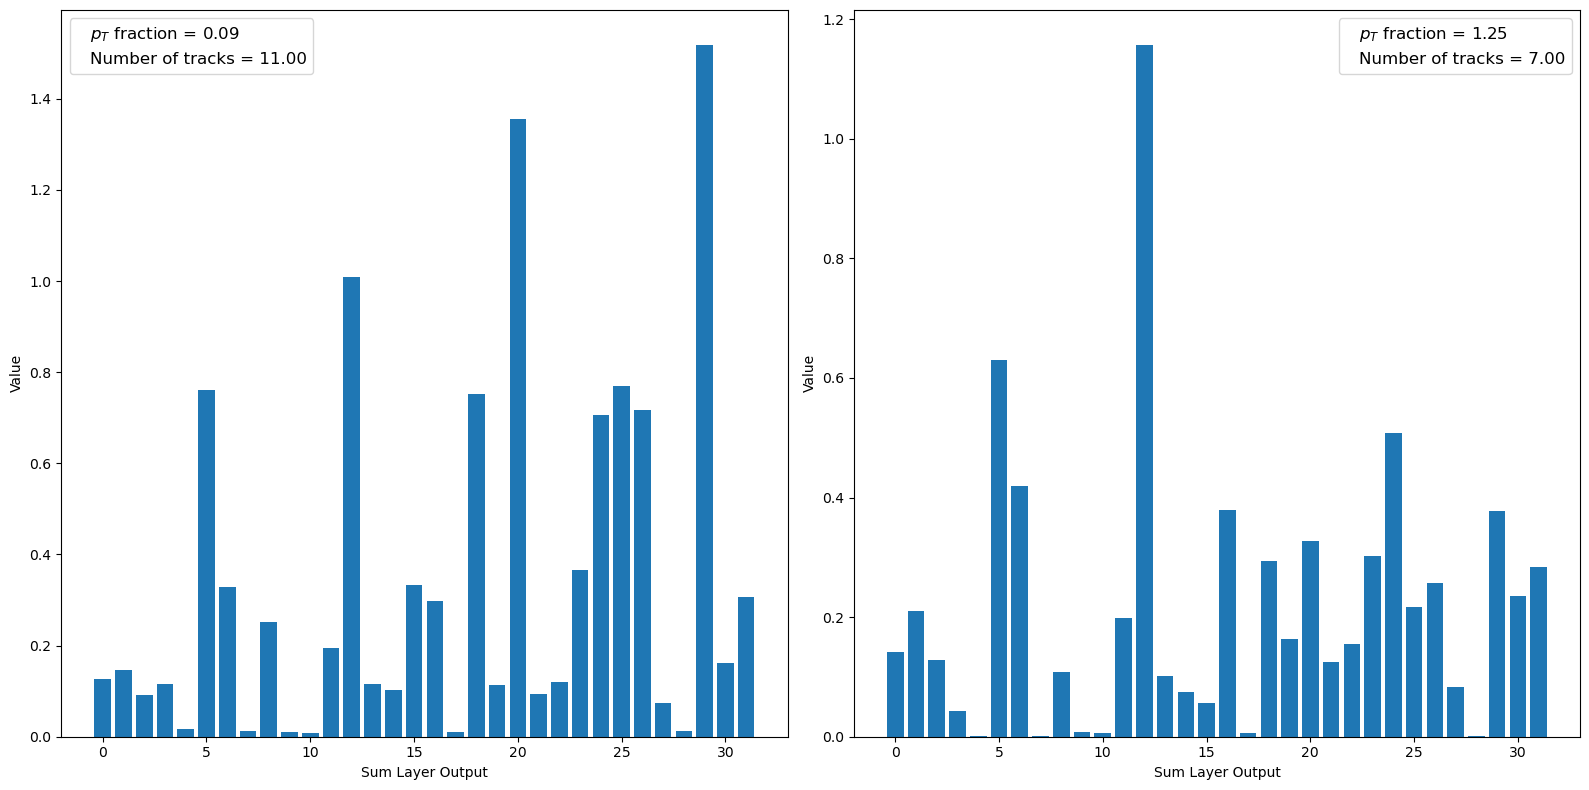

In [71]:
xs = numpy.arange(0,32,1)
print(xs)
fig, axes = plt.subplots(1,2, figsize = (16,8))
pxlabel = r'$p_T $ fraction'+ ' = {:.2f}'.format(y_valid[x, 6])
axes[0].bar(xs, sum[x], label = pxlabel)
pxlabel2 = r'$p_T$ fraction'+ ' = {:.2f}'.format(y_valid[y, 6])
axes[1].bar(xs, sum[y], label = pxlabel2)
axes[0].set(xlabel = 'Sum Layer Output', ylabel = 'Value')
axes[1].set(xlabel = 'Sum Layer Output', ylabel = 'Value')

handles, labels = axes[1].get_legend_handles_labels()
handles1 = [h[0] for h in handles]

handles, labels = axes[0].get_legend_handles_labels()
label = 'Number of tracks = {:.2f}'.format(numpy.sum(sum[x]))
labels.append(label)
handles = handles1
handles.append(handles1[0])
axes[0].legend(labels = labels, handles = handles, handlelength = 0, fontsize = 'large')

handles, labels = axes[1].get_legend_handles_labels()
label = 'Number of tracks = {:.2f}'.format(numpy.sum(sum[y]))
labels.append(label)
handles = handles1
handles.append(handles1[0])
axes[1].legend(fontsize = 'large', labels = labels, handles = handles, handlelength = 0)


plt.tight_layout()
plt.show()
plt.close()

C:\Users\u2041835\AppData\Local\Temp\ipykernel_5296\282536443.py:18: UserWarning: Legend does not support [<matplotlib.patches.Rectangle object at 0x000002470389A220>, <matplotlib.patches.Rectangle object at 0x00000247038C53D0>, [...]] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  axes.legend(labels = labels, handles = handles, fontsize = 'large')
C:\Users\u2041835\AppData\Local\Temp\ipykernel_5296\282536443.py:25: UserWarning: Legend does not support [<matplotlib.patches.Rectangle object at 0x000002470389A220>, <matplotlib.patches.Rectangle object at 0x00000247038C53D0>, [...], <matplotlib.patches.Rectangle object at 0x000002470389A220>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  axes.legend(fontsize = 'large', labels = labels, ha

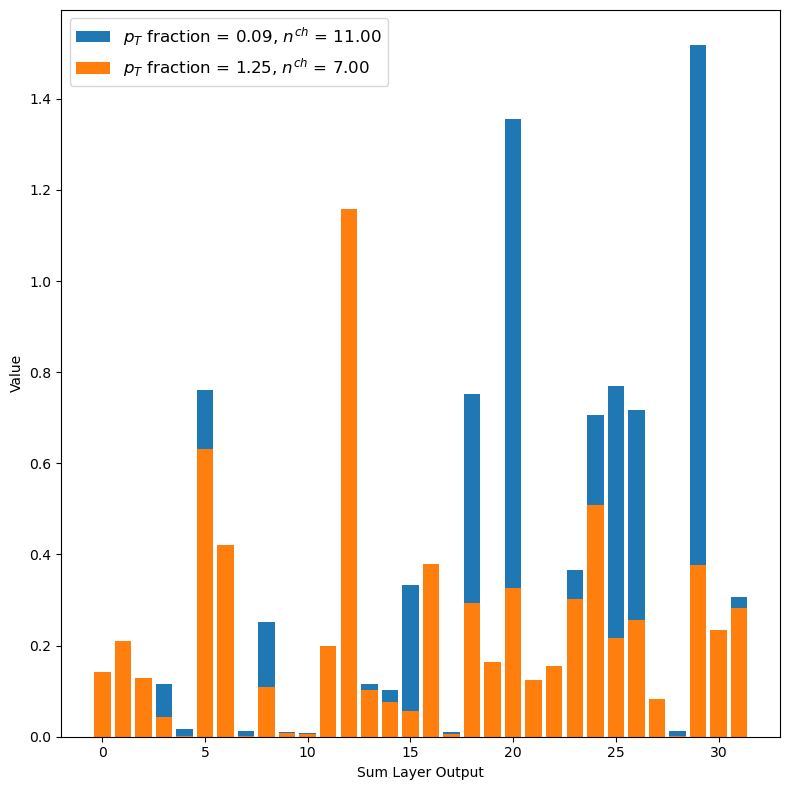

In [72]:
xs = numpy.arange(0,32,1)
fig, axes = plt.subplots(1,1, figsize = (8,8))
pxlabel = (r'$p_T $ fraction'+ ' = {:.2f}'.format(y_valid[x, 6]) + r", $n^{ch}$ = " + '{:.2f}'.format(numpy.sum(sum[x])))
axes.bar(xs, sum[x], label = pxlabel)
pxlabel2 = (r'$p_T$ fraction'+ ' = {:.2f}'.format(y_valid[y, 6]) + r", $n^{ch}$ = " + '{:.2f}'.format(numpy.sum(sum[y])))
axes.bar(xs, sum[y], label = pxlabel2)
axes.set(xlabel = 'Sum Layer Output', ylabel = 'Value')
axes.set(xlabel = 'Sum Layer Output', ylabel = 'Value')

handles, labels = axes.get_legend_handles_labels()
handles1 = [h[0] for h in handles]

handles, labels = axes.get_legend_handles_labels()
label = 'Number of tracks = {:.2f}'.format(numpy.sum(sum[x]))
labels.append(label)
handles = handles1
handles.append(handles1)
axes.legend(labels = labels, handles = handles, fontsize = 'large')

handles, labels = axes.get_legend_handles_labels()
label = 'Number of tracks = {:.2f}'.format(numpy.sum(sum[y]))
labels.append(label)
handles = handles1
handles.append(handles1[0])
axes.legend(fontsize = 'large', labels = labels, handles = handles)


plt.tight_layout()
plt.show()
plt.close()

In [73]:
sum[y]

array([0.14, 0.21, 0.13, 0.04, 0.  , 0.63, 0.42, 0.  , 0.11, 0.01, 0.01,
       0.2 , 1.16, 0.1 , 0.08, 0.06, 0.38, 0.01, 0.29, 0.16, 0.33, 0.12,
       0.15, 0.3 , 0.51, 0.22, 0.26, 0.08, 0.  , 0.38, 0.23, 0.28],
      dtype=float32)

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (16,8))
plt.suptitle("Sum Layer Output")
pxlabel = r'$p_T $ fraction'+ ' = {:.2f}'.format(y_valid[x, 6])
binneddensitysub(sum[x], ax=axes[0], binning = fixedbinning(0,40, 32), xlabel = 'Sum Layer Output', label = pxlabel)

pxlabel2 = r'$p_T$ fraction'+ ' = {:.2f}'.format(y_valid[598, 6])
binneddensitysub(sum[598], ax=axes[1], binning = fixedbinning(0,2,32), xlabel = 'Sum Layer Output', label = pxlabel2)


handles, labels = axes[0].get_legend_handles_labels()
label = 'Number of tracks = {:.2f}'.format(numpy.sum(sum[x]))
labels.append(label)
handles = handles1
handles.append(handles1[0])
axes[0].legend(labels = labels, handles = handles, handlelength = 0, fontsize = 'large')

handles, labels = axes[1].get_legend_handles_labels()
label = 'Number of tracks = {:.2f}'.format(numpy.sum(sum[y]))
labels.append(label)
handles = handles1
handles.append(handles1[0])
axes[1].legend(fontsize = 'large', labels = labels, handles = handles, handlelength = 0)




plt.tight_layout()
plt.show()

In [ ]:
numtracks = numpy.ma.sum(sum, axis=-1)
fig = binneddensity(numtracks, fixedbinning(0,32,32), xlabel= "Number of Tracks in Jet")
fig, axes = plt.subplots(figsize = (12,12))
label = (r"$ \mu \pm \sigma$ = {:.2f} $\pm$ {:.2f}".format(numpy.mean(numtracks), numpy.std(numtracks)))    
binneddensitysub(numpy.ma.sum(sum, axis=-1), fixedbinning(0,32, 32), xlabel = "Number of Tracks in in Jet", ax=axes, label = label)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(12,10))
plt.suptitle("Sum Layer Outputs")
x = 2
pxlabel = r'$p_T $ fraction'+ ' = {:.2f}'.format(y_valid[x, 6])
binneddensitysub(sum[x], ax=axes[0,0], binning = fixedbinning(0,2, 32), label = pxlabel)
axes[0,0].set_xlabel(xlabel = 'Sum Layer Output', fontsize='large')
axes[0,0].set_ylabel(ylabel = "Binned Probability Density", fontsize='large')
axes[0,0].tick_params(axis='both', labelsize='large')
y = 598
pxlabel2 = r'$p_T$ fraction'+ ' = {:.2f}'.format(y_valid[598, 6])
binneddensitysub(sum[598], ax=axes[0,1], binning = fixedbinning(0,2,32), xlabel = 'Sum Layer Output', label = pxlabel2)
axes[0,1].set_xlabel(xlabel = 'Sum Layer Output', fontsize='large')
axes[0,1].set_ylabel(ylabel = "Binned Probability Density", fontsize='large')
axes[0,1].tick_params(axis='both', labelsize='large')

handles, labels = axes[0,0].get_legend_handles_labels()
label = 'Number of tracks = {:.2f}'.format(numpy.sum(sum[x]))
labels.append(label)
handles = handles1
handles.append(handles1[0])
axes[0,0].legend(labels = labels, handles = handles, handlelength = 0, fontsize = 'large')

handles, labels = axes[0,1].get_legend_handles_labels()
label = 'Number of tracks = {:.2f}'.format(numpy.sum(sum[y]))
labels.append(label)
handles = handles1
handles.append(handles1[0])
axes[0,1].legend(fontsize = 'large', labels = labels, handles = handles, handlelength = 0)

histo = axes[1,0].hist2d(y_valid[:,6], numtracks, bins = 31, cmap = 'hot', range = [[0,1.5],[0,32]])
axes[1,0].set(xlim = (0,1.5),ylim = (0,25))   
axes[1,0].set_xlabel(xlabel = r"$z_{L,b}$", fontsize='large')
axes[1,0].set_ylabel(ylabel = "Number of Tracks", fontsize='large')
axes[1,0].tick_params(axis='both', labelsize='large')

binneddensitysub(numpy.ma.sum(sum, axis=-1), fixedbinning(0,32, 32), xlabel = "Number of Tracks in in Jet", ax=axes[1,1])
handles, labels = axes[1,1].get_legend_handles_labels()
label = (r"$ \mu \pm \sigma$ = {:.2f} $\pm$ {:.2f}".format(numpy.mean(numtracks), numpy.std(numtracks))) 
labels.append(label)
handles = handles1
axes[1,1].set_xlabel(xlabel = r"$n^{ch}$", fontsize='large')
axes[1,1].set_ylabel(ylabel = "Binned Probability Density", fontsize='large')
axes[1,1].tick_params(axis='both', labelsize='large')
axes[1,1].legend(fontsize = 'large', labels = labels, handles = handles, handlelength = 0)

fig.colorbar(histo[3], ax=axes[1,0])
plt.tight_layout()
plt.show()

In [77]:
r2_test = r2_score(y_valid[:,6], numtracks)
correlation, pval = pearsonr(y_valid[:,6], numtracks)
print(r2_test, correlation, pval)
from scipy.stats import spearmanr, kendalltau, pointbiserialr
correlation, pval = spearmanr(y_valid[:,6], numtracks)
print(correlation, pval)
correlation, pval = kendalltau(y_valid[:,6], numtracks)
print(correlation, pval)
correlation, pval = pointbiserialr(y_valid[:,6], numtracks)
print(correlation, pval)

-2330.540759581715 -0.41399908449808737 0.0
-0.4530410134000662 0.0
-0.32293321413683584 0.0
-0.41399908449808737 0.0


In [ ]:
history_df = (pd.DataFrame(history.history))
fig, axes = plt.subplots(figsize=(12,12))
axes.plot(history_df.loc[:,['loss']], label= 'Loss', color = 'b', alpha = 0.6)
axes.plot(history_df.loc[:,['val_loss']], label= 'Validation Loss', color = 'orange', alpha = 0.6)
axes.set(xlabel = 'Epoch', ylabel = 'Loss')
axes2 = axes.twinx()
axes2.plot(history_df.loc[:, 'RegressionOuts_lr'], label = 'Learning Rate', color = 'r', alpha = 0.6)
axes2.set(ylabel = 'Learning Rate')
handles1, labels1 = axes.get_legend_handles_labels()
handles2, labels2 = axes2.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2
axes.legend(handles, labels)
plt.tight_layout()
plt.show()
plt.savefig("LossLRCurve")
plt.close()

In [ ]:
#Saves the model
#model.save('Model')
#model.save_weights('Model Weights 5000 epoch.h5')

In [ ]:
# Uses the model to predict validation set
pred, pred2 = model.predict([X1_valid, X2_valid, X3_valid])

In [46]:
import numpy
#pred = numpy.load("TranProj Reg Preds Val.npy")
pred =numpy.load("S Preds.npy")
#pred = numpy.load("LepClass Preds Train.npy")
pred2 = numpy.load("SC Preds.npy")
print(numpy.shape(pred))
X1_train = numpy.load("SX1_train.npy")
X2_train = numpy.load("SX2_train.npy")
#X3_train = numpy.load("MVX3_train.npy")
y_train = numpy.load("Sy_train.npy")
y2_train = numpy.load("Sy2_train.npy")
X1_valid = numpy.load("SX1_valid.npy")
X2_valid = numpy.load("SX2_valid.npy")
#X3_valid = numpy.load("MVX3_valid.npy")
y_valid = numpy.load("Sy_valid.npy")
y2_valid = numpy.load("Sy2_valid.npy")





pred[:,numtargets:2*numtargets] = numpy.exp(pred[:,numtargets:2*numtargets])


pred[:,3]=pred[:,3]*10**3
y_valid[:,3] = y_valid[:,3]*10**3
pred[:,numtargets+3] = pred[:,numtargets+3]*10**3


diffs = y_valid[:,:9] - pred[:,:9]
err = pred[:, numtargets:2*numtargets]
pull = diffs/err[:,:9]
percDiff = diffs/y_valid[:,:9]


(16991, 380)


In [50]:
#pred2 = clf.predict_proba(rf_valid_inputs)
pred3arg = pred2.argmax(axis = 1) # Find Index of maximum
prob_pred = pred2[range(len(pred3arg)), pred3arg]

In [51]:
conf_mat = confusion_matrix(y2_valid, pred3arg, normalize='all')
cmd = ConfusionMatrixDisplay(conf_mat)

row_sums = conf_mat.sum(axis=1, keepdims = True)
norm_confusion_matrix = conf_mat/row_sums
numpy.fill_diagonal(norm_confusion_matrix, 0)
cmde = ConfusionMatrixDisplay(norm_confusion_matrix)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(numpy.unique(y2_valid))):
    fpr[i], tpr[i], _ = roc_curve(y2_valid == i, pred2[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

precision = {}
recall = {}
thresholds = {}
pr_auc ={}
for i in range(len(numpy.unique(y2_valid))):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y2_valid == i, pred2[:,i])
    #pr_auc[i] = auc(precision[i], recall[i])

f1_scores = []
for i in range(len(numpy.unique(y2_valid))):
    f1 = f1_score(y2_valid, pred3arg, labels=[i], average='weighted')
    f1_scores.append(f1)
f1_scores = numpy.round(f1_scores, 2)

balanced_accuracy = balanced_accuracy_score(y2_valid, pred3arg) 
accuracy = accuracy_score(y2_valid, pred3arg)

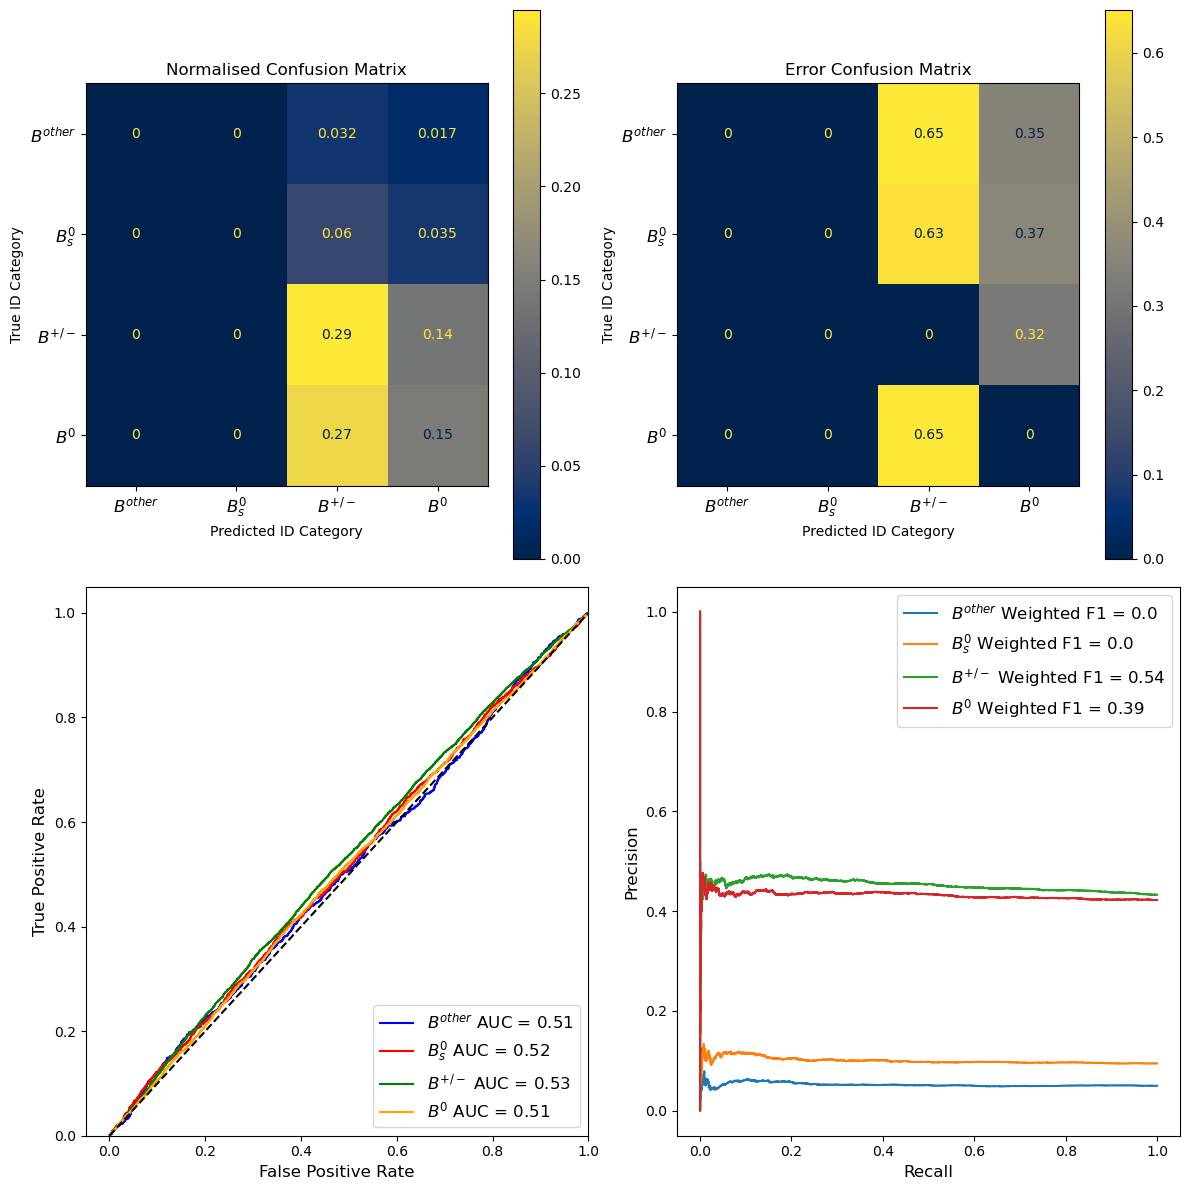

In [89]:
Mesons = ['$B^{other}$', '$B^0_s$', '$B^{+/-}$', '$B^0$']
fig, axes = plt.subplots(2,2, figsize = (12,12))
cmd.plot(ax=axes[0,0], cmap = plt.cm.cividis)
axes[0,0].set(xlabel = 'Predicted ID Category', ylabel = 'True ID Category')
#axes[0,0].xaxis.set_label_position('top')
#axes[0,0].xaxis.set_ticks_position('top')
axes[0,0].set_xticklabels(Mesons, fontsize = 'large')
axes[0,0].set_yticklabels(Mesons, fontsize= 'large')
axes[0,0].set_title('Normalised Confusion Matrix')

cmde.plot(ax=axes[0,1], cmap=plt.cm.cividis)
axes[0,1].set(xlabel = 'Predicted ID Category', ylabel = 'True ID Category')
#axes[0,1].xaxis.set_label_position('top')
#axes[0,1].xaxis.set_ticks_position('top')
axes[0,1].set_xticklabels(Mesons, fontsize = 'large')
axes[0,1].set_yticklabels(Mesons, fontsize = 'large')
axes[0,1].set_title("Error Confusion Matrix")

colorsc = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(len(numpy.unique(y2_valid))), colorsc):
    axes[1,0].plot(fpr[i], tpr[i], color=color,
             label='{0} AUC = {1:0.2f}'
             ''.format(Mesons[i], roc_auc[i]))
axes[1,0].plot([0, 1], [0, 1], 'k--')
axes[1,0].set(xlim = ([-0.05, 1.0]), ylim = ([0.0, 1.05]), xlabel = ('False Positive Rate'), ylabel = ('True Positive Rate'))
axes[1,0].legend(loc="lower right", fontsize = 'large')
axes[1,0].set_xlabel("False Positive Rate", fontsize='large')
axes[1,0].set_ylabel("True Positive Rate", fontsize = 'large')



for i in range(len(numpy.unique(y2_valid))):
    #axes[1,1].plot(recall[i], precision[i], label=str(('Class {}, Weighted F1 = ', str(f1_scores[i]))).format(i))
    axes[1,1].plot(recall[i], precision[i], label = (str(Mesons[i])+ ' Weighted F1 = '+ str(f1_scores[i])))
    #axes[1,1].plot(recall[i], precision[i], label = (str(Mesons[i])+ ' AUC = {1:0.2f}'.format(pr_auc[i])+ str(f1_scores[i])))
    axes[1,1].set_xlabel('Recall', fontsize = 'large')
    axes[1,1].set_ylabel('Precision', fontsize = 'large')
    axes[1,1].legend(fontsize = 'large')


plt.tight_layout()
plt.show()

[0.   0.   0.54 0.39]


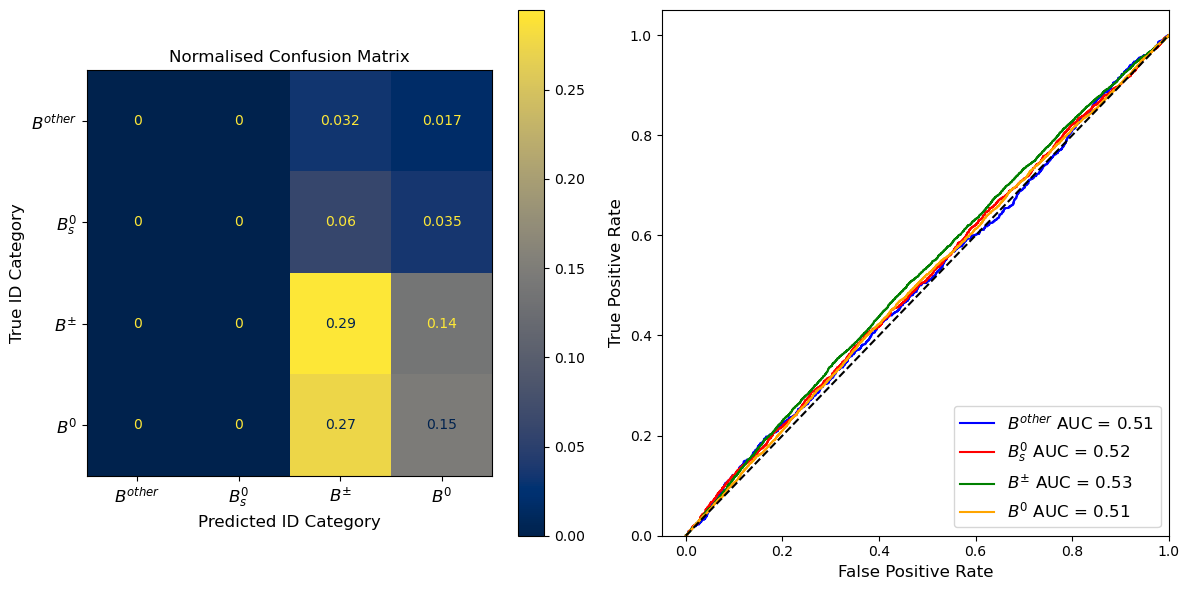

In [66]:
Mesons = ['$B^{other}$', '$B^0_s$', '$B^{\pm}$', '$B^0$']
print(f1_scores)
fig, axes = plt.subplots(1,2, figsize = (12,6))
cmd.plot(ax=axes[0], cmap = plt.cm.cividis)
axes[0].set_xlabel('Predicted ID Category', fontsize = 'large')
axes[0].set_ylabel('True ID Category', fontsize = 'large')
#axes[0,0].xaxis.set_label_position('top')
#axes[0,0].xaxis.set_ticks_position('top')
axes[0].set_xticklabels(Mesons, fontsize = 'large')
axes[0].set_yticklabels(Mesons, fontsize= 'large')
axes[0].set_title('Normalised Confusion Matrix', fontsize='large')


colorsc = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(len(numpy.unique(y2_valid))), colorsc):
    axes[1].plot(fpr[i], tpr[i], color=color,
             label='{0} AUC = {1:0.2f}'
             ''.format(Mesons[i], roc_auc[i]))
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set(xlim = ([-0.05, 1.0]), ylim = ([0.0, 1.05]), xlabel = ('False Positive Rate'), ylabel = ('True Positive Rate'))
axes[1].legend(loc="lower right", fontsize = 'large')
axes[1].set_xlabel("False Positive Rate", fontsize='large')
axes[1].set_ylabel("True Positive Rate", fontsize = 'large')



plt.tight_layout()
plt.savefig("Class.pdf")
plt.show()

In [105]:
#####OLD HERE######


In [80]:
def plotting(w, title, unit=''):
    fig, axes = plt.subplots(2,2, figsize = (12,12))
    plt.suptitle(title)
    lims = alims[w]

    x = y_valid[:,w]
    y = pred[:,w]
    grid = numpy.vstack([x, y])
    density = gaussian_kde(grid)(grid)
    r2 = r2_score(x, y)
    corr, p_value = pearsonr(x, y)

    scatter = axes[0,0].scatter(x, y, c = density, cmap="hot", s = 2.5, norm = colors.PowerNorm(gamma=0.75), label='R\u00B2 Score = {:.2f}'.format(r2))
    fig.colorbar(scatter, ax = axes[0,0])


    label = r'True $\mu \pm \sigma =$ {:.2e} $\pm$ {:.2e}'.format(numpy.mean(x), numpy.std(x))
    binneddensitysub(x, fixedbinning(lims[0], lims[1], nbins = 100), ax = axes[0,1], xlabel= 'Predicted' + unit, label = label)


    label = r'Predicted $\mu \pm \sigma =$ {:.2e} $\pm$ {:.2e}'.format(numpy.mean(y), numpy.std(y))
    binneddensitysub(y , fixedbinning(lims[0], lims[1], nbins = 100), ax = axes[0,1], xlabel= 'Distribution '+ unit, label = label)

    label = r'$\mu \pm \sigma =$ {:.2e} $\pm$ {:.2e}'.format(numpy.mean(diffs[:,w]), numpy.std(diffs[:,w]))
    binneddensitysub(diffs[:,w], fixedbinning(-lims[1], lims[1], nbins = 100), ax = axes[1,0], xlabel= 'Difference ' +unit , label = label)

    label = r'Pull $\mu \pm \sigma =$ {:.2f} $\pm$ {:.2f}'.format(numpy.mean(pull[:,w]), numpy.std(pull[:,w]))
    binneddensitysub(pull[:,w], fixedbinning(-2.5,2.5, nbins = 100), ax = axes[1,1], xlabel= ' Pull ', label = label)

    label = r'Relative Diff $\mu \pm \sigma =$ {:.2f} $\pm$ {:.2f}'.format(numpy.median(percDiff[:,w]), numpy.quantile(percDiff[:,w], 0.75) - numpy.quantile(percDiff[:,w],0.25))    
    binneddensitysub(percDiff[:,w], fixedbinning(-2.5,2.5, nbins = 100), ax = axes[1,1], xlabel = 'Scaled Differences', label = label)
    global handles1
    handles, labels = axes[1,1].get_legend_handles_labels()
    handles1 = [h[0] for h in handles]
    axes[1,1].legend(handles=handles1, labels=labels, handlelength = 0)

    axes[0,0].set(xlabel='True '+unit, ylabel='Predicted '+ unit, xlim = lims, ylim = lims)
    axes[0,0].plot(lims,lims)
    handles, labels = axes[0,0].get_legend_handles_labels()
    corr_label = r'Correlation = {:.2f}'.format(corr)
    p_label = r'P-Value = {:.3e}'.format(p_value)
    labels.append(corr_label)
    labels.append(p_label)
    handles = handles1
    handles.append(handles1[0])
    handles.append(handles1[0])
    axes[0,0].legend(labels = labels, handles = handles, handlelength = 0, fontsize = 'large')

    handles, labels = axes[0,1].get_legend_handles_labels()
    axes[0,1].legend(handles=handles, labels=labels, fontsize = 'large')

    handles, labels = axes[1,0].get_legend_handles_labels()
    handles = [h[0] for h in handles]
    axes[1,0].legend(handles=handles, labels=labels, handlelength = 0, fontsize = 'large')
                    
    handles, labels = axes[1,1].get_legend_handles_labels()
    axes[1,1].legend(handles = handles, labels = labels, fontsize = 'large', loc = 'upper left')


    axes[0,0].set_xlabel('True ' + unit, fontsize='large')
    axes[0,0].set_ylabel('Predicted ' + unit, fontsize='large')
    axes[0,0].tick_params(axis='both', labelsize='large')

    axes[0,1].set_xlabel('Distribution ' + unit, fontsize='large')
    axes[0,1].set_ylabel('Binned Probability Density', fontsize='large')
    axes[0,1].tick_params(axis='both', labelsize='large')

    axes[1,0].set_xlabel('Difference ' + unit, fontsize='large')
    axes[1,0].set_ylabel('Binned Probability Density' , fontsize='large')
    axes[1,0].tick_params(axis='both', labelsize='large')

    axes[1,1].set_xlabel('Scaled Differences ', fontsize='large')
    axes[1,1].set_ylabel('Binned probability density', fontsize='large')
    axes[1,1].tick_params(axis='both', labelsize='large')

    plt.tight_layout()
    plt.show()
    plt.close()

alims = [(-150000*10**-6, 150000*10**-6),(-150000*10**-6, 150000*10**-6),(-250000*10**-6, 250000*10**-6),(0, 150000*10**-6),(0,400000*10**-6),(0,400000*10**-6), (0,1.5),(0,1.5), (0,10)]

In [88]:
def plottingScatter(title):
    fig, axes = plt.subplots(2,2, figsize = (16,12))
    plt.suptitle(title)
    w=3
    lims = alims[w]

    x = y_valid[:,w]
    y = pred[:,w]
    grid = numpy.vstack([x, y])
    density = gaussian_kde(grid)(grid)
    r2 = r2_score(x, y)
    corr, p_value = pearsonr(x, y)

    scatter = axes[0,0].scatter(x, y, c = density, cmap="hot", s = 2.5, norm = colors.PowerNorm(gamma=0.75), label='R\u00B2 Score = {:.2f}'.format(r2))
    fig.colorbar(scatter, ax = axes[0,0])


    axes[0,0].set(xlabel='True $p_T$ (TeV)', ylabel='Predicted $p_T$ (TeV)', xlim = lims, ylim = lims)
    axes[0,0].plot(lims,lims)
    
    handles, labels = axes[0,0].get_legend_handles_labels()
    corr_label = r'Correlation = {:.2f}'.format(corr)
    labels.append(corr_label)
    handles = handles1
    handles.append(handles1[0])
    axes[0,0].legend(labels = labels, handles = handles, handlelength = 0, fontsize = 'large')
    axes[0,0].set_xlabel('True $p_T$ (TeV) ', fontsize='large')
    axes[0,0].set_ylabel('Predicted $p_T$ (MeV)', fontsize='large')
    axes[0,0].tick_params(axis='both', labelsize='large')
    w = 8
    lims = alims[w]

    x = y_valid[:,w]
    y = pred[:,w]
    grid = numpy.vstack([x, y])
    density = gaussian_kde(grid)(grid)
    r2 = r2_score(x, y)
    corr, p_value = pearsonr(x, y)

    scatter = axes[0,1].scatter(x, y, c = density, cmap="hot", s = 2.5, norm = colors.PowerNorm(gamma=0.75), label='R\u00B2 Score = {:.2f}'.format(r2))
    fig.colorbar(scatter, ax = axes[0,1])


    axes[0,1].set(xlabel=r'True $p_T^{rel}$', ylabel=r'Predicted $p_T^{rel}$', xlim = lims, ylim = lims)
    axes[0,1].plot(lims,lims)
    
    handles, labels = axes[0,1].get_legend_handles_labels()
    corr_label = r'Correlation = {:.2f}'.format(corr)
    labels.append(corr_label)
    handles = handles1
    handles.append(handles1[0])
    axes[0,1].legend(labels = labels, handles = handles, handlelength = 0, fontsize = 'large')
    axes[0,1].set_xlabel(r'True $p_T^{rel}$ (GeV)', fontsize='large')
    axes[0,1].set_ylabel(r'Predicted $p_T^{rel}$ (GeV)', fontsize='large')
    axes[0,1].tick_params(axis='both', labelsize='large')

    w = 6
    lims = alims[w]

    x = y_valid[:,w]
    y = pred[:,w]
    grid = numpy.vstack([x, y])
    density = gaussian_kde(grid)(grid)
    r2 = r2_score(x, y)
    corr, p_value = pearsonr(x, y)

    scatter = axes[1,0].scatter(x, y, c = density, cmap="hot", s = 2.5, norm = colors.PowerNorm(gamma=0.75), label='R\u00B2 Score = {:.2f}'.format(r2))
    fig.colorbar(scatter, ax = axes[1,0])


    axes[1,0].set(xlabel=r'True $z_{T,b}$', ylabel='Predicted ', xlim = lims, ylim = lims)
    axes[1,0].plot(lims,lims)

    handles, labels = axes[1,0].get_legend_handles_labels()
    corr_label = r'Correlation = {:.2f}'.format(corr)
    labels.append(corr_label)
    handles = handles1
    handles.append(handles1[0])
    axes[1,0].legend(labels = labels, handles = handles, handlelength = 0, fontsize = 'large')
    axes[1,0].set_xlabel(r'True $z_{T,b}$ ', fontsize='large')
    axes[1,0].set_ylabel(r'Predicted $z_{T,b}$ ', fontsize='large')
    axes[1,0].tick_params(axis='both', labelsize='large')


    w = 7
    lims = alims[w]

    x = y_valid[:,w]
    y = pred[:,w]
    grid = numpy.vstack([x, y])
    density = gaussian_kde(grid)(grid)
    r2 = r2_score(x, y)
    corr, p_value = pearsonr(x, y)

    scatter = axes[1,1].scatter(x, y, c = density, cmap="hot", s = 2.5, norm = colors.PowerNorm(gamma=0.75), label='R\u00B2 Score = {:.2f}'.format(r2))
    fig.colorbar(scatter, ax = axes[1,1])


    axes[1,1].set(xlabel=r'True $z_{L,b}$', ylabel=r'$Predicted test$', xlim = lims, ylim = lims)
    axes[1,1].plot(lims,lims)
    
    handles, labels = axes[1,1].get_legend_handles_labels()
    corr_label = r'Correlation = {:.2f}'.format(corr)
    labels.append(corr_label)
    handles = handles1
    handles.append(handles1[0])
    axes[1,1].legend(labels = labels, handles = handles, handlelength = 0, fontsize = 'large')
    axes[1,1].set_xlabel('True $z_{L,b}$' , fontsize='large')
    axes[1,1].set_ylabel('Predicted $z_{L,b}$', fontsize='large')
    axes[1,1].tick_params(axis='both', labelsize='large')

    
    plt.tight_layout()
    plt.savefig("KDE.pdf")
    plt.show()

    plt.close()

alims = [(-150000*10**-6, 150000*10**-6),(-150000*10**-6, 150000*10**-6),(-250000*10**-6, 250000*10**-6),(0, 150000*10**-3),(0,400000*10**-6),(0,400000*10**-6), (0,1.5),(0,1.5), (0,10)]

In [82]:
def plottingPull(title):
    fig, axes = plt.subplots(2,2, figsize = (16,12))
    plt.suptitle(title)
    w=3

    label = r'Pull $\mu \pm \sigma =$ {:.2f} $\pm$ {:.2f}'.format(numpy.mean(pull[:,w]), numpy.std(pull[:,w]))
    binneddensitysub(pull[:,w], fixedbinning(-2.5,2.5, nbins = 100), ax = axes[0,0], xlabel= ' Pull ', label = label)

    label = r'Relative Diff $\mu \pm \sigma =$ {:.2f} $\pm$ {:.2f}'.format(numpy.median(percDiff[:,w]), numpy.quantile(percDiff[:,w], 0.75) - numpy.quantile(percDiff[:,w],0.25))    
    binneddensitysub(percDiff[:,w], fixedbinning(-2.5,2.5, nbins = 100), ax = axes[0,0], xlabel = 'Scaled Differences', label = label)

    axes[0,0].set_xlabel(r'$p_T$  ', fontsize='large')
    axes[0,0].set_ylabel('Binned probability density', fontsize='large')
    axes[0,0].tick_params(axis='both', labelsize='large')

    handles, labels = axes[0,0].get_legend_handles_labels()
    axes[0,0].legend(handles=handles, labels=labels, fontsize = 'large')

    w=8

    label = r'Pull $\mu \pm \sigma =$ {:.2f} $\pm$ {:.2f}'.format(numpy.mean(pull[:,w]), numpy.std(pull[:,w]))
    binneddensitysub(pull[:,w], fixedbinning(-2.5,2.5, nbins = 100), ax = axes[0,1], xlabel= ' Pull ', label = label)

    label = r'Relative Diff $\mu \pm \sigma =$ {:.2f} $\pm$ {:.2f}'.format(numpy.median(percDiff[:,w]), numpy.quantile(percDiff[:,w], 0.75) - numpy.quantile(percDiff[:,w],0.25))    
    binneddensitysub(percDiff[:,w], fixedbinning(-2.5,2.5, nbins = 100), ax = axes[0,1], xlabel = 'Scaled Differences', label = label)

    axes[0,1].set_xlabel(r'$p_T^{rel}$ ', fontsize='large')
    axes[0,1].set_ylabel('Binned probability density', fontsize='large')
    axes[0,1].tick_params(axis='both', labelsize='large')

    handles, labels = axes[0,1].get_legend_handles_labels()
    axes[0,1].legend(handles = handles, labels = labels, fontsize = 'large', loc = 'upper left')

    w=6

    label = r'Pull $\mu \pm \sigma =$ {:.2f} $\pm$ {:.2f}'.format(numpy.mean(pull[:,w]), numpy.std(pull[:,w]))
    binneddensitysub(pull[:,w], fixedbinning(-2.5,2.5, nbins = 100), ax = axes[1,0], xlabel= ' Pull ', label = label)

    label = r'Relative Diff $\mu \pm \sigma =$ {:.2f} $\pm$ {:.2f}'.format(numpy.median(percDiff[:,w]), numpy.quantile(percDiff[:,w], 0.75) - numpy.quantile(percDiff[:,w],0.25))    
    binneddensitysub(percDiff[:,w], fixedbinning(-2.5,2.5, nbins = 100), ax = axes[1,0], xlabel = 'Scaled Differences', label = label)

    axes[1,0].set_xlabel(r'$z_{T,b}$ ', fontsize='large')
    axes[1,0].set_ylabel('Binned probability density', fontsize='large')
    axes[1,0].tick_params(axis='both', labelsize='large')

    handles, labels = axes[1,0].get_legend_handles_labels()
    axes[1,0].legend(handles = handles, labels = labels, fontsize = 'large', loc = 'upper left')

    w=7

    label = r'Pull $\mu \pm \sigma =$ {:.2f} $\pm$ {:.2f}'.format(numpy.mean(pull[:,w]), numpy.std(pull[:,w]))
    binneddensitysub(pull[:,w], fixedbinning(-2.5,2.5, nbins = 100), ax = axes[1,1], xlabel= ' Pull ', label = label)

    label = r'Relative Diff $\mu \pm \sigma =$ {:.2f} $\pm$ {:.2f}'.format(numpy.median(percDiff[:,w]), numpy.quantile(percDiff[:,w], 0.75) - numpy.quantile(percDiff[:,w],0.25))    
    binneddensitysub(percDiff[:,w], fixedbinning(-2.5,2.5, nbins = 100), ax = axes[1,1], xlabel = 'Scaled Differences', label = label)

    axes[1,1].set_xlabel(r'$z_{L,b}$ ', fontsize='large')
    axes[1,1].set_ylabel('Binned probability density', fontsize='large')
    axes[1,1].tick_params(axis='both', labelsize='large')

    handles, labels = axes[1,1].get_legend_handles_labels()
    axes[1,1].legend(handles = handles, labels = labels, fontsize = 'large', loc = 'upper left')

    plt.tight_layout()
    plt.show()
    plt.close()

In [54]:
import tensorflow_probability as tfp
mvn = tfp.distributions.Normal(pred[:,7].astype(numpy.float32), scale = err[:,7])
probproj = numpy.log(mvn.prob(y_valid[:,7]).numpy())
mvn = tfp.distributions.Normal(pred[:,6], scale = err[:,6])
probfrac = numpy.log(mvn.prob(y_valid[:,6]).numpy())
mvn = tfp.distributions.Normal(pred[:,3], scale = err[:,3])
probpT = numpy.log(mvn.prob(y_valid[:,3]).numpy())
mvn = tfp.distributions.Normal(pred[:,8], scale = err[:,8])
probprojt = numpy.log(mvn.prob(y_valid[:,8]).numpy())
a = [0.24, 0.09, 0.04,0.09,0.29, 0.13, 0.01, 0.16, 0.23, 0.08, 0.0005, 0.1, 0.07]
b = [0.85, 0.33,0.32, 0.48, 0.92, 0.57, 0.02, 0.46, 0.71, 0.42, 0.005, 0.47, 0.53]

<ipython-input-54-b038e986437a>:9: RuntimeWarning: divide by zero encountered in log
  probprojt = numpy.log(mvn.prob(y_valid[:,8]).numpy())


In [ ]:
fig, axes = plt.subplots(2,2, figsize = (12,12))
binneddensitysub(probpT, fixedbinning(0,4,100), xlabel = 'pT p-values', ax = axes[0,0])
binneddensitysub(probprojt, fixedbinning(-10,10,100), xlabel = 'Transverse Projection p-values', ax = axes[0,1])
binneddensitysub(probfrac, fixedbinning(0,1, 100), ax=axes[1,0])
binneddensitysub(a, fixedbinning(0,1,15), ax=axes[1,0], xlabel = 'Fraction p-Values')
binneddensitysub(probproj, fixedbinning(0,1,100), ax = axes[1,1])
binneddensitysub(b, fixedbinning(0,1,15), ax=axes[1,1], xlabel = 'Longitudinal Projection p-values')
plt.tight_layout()
plt.show()

In [121]:
print("Errors")
print(numpy.mean(diffs[:,3]), numpy.std(diffs[:,3]))
print(numpy.median(diffs[:,8]), numpy.quantile(diffs[:,8], 0.75)-numpy.quantile(diffs[:,8], 0.25))
print(numpy.mean(diffs[:,6]), numpy.std(diffs[:,6]))
print(numpy.mean(diffs[:,7]), numpy.std(diffs[:,7]))

print("Trues")
print(numpy.mean(y_valid[:,3]), numpy.std(y_valid[:,3]))
print(numpy.median(y_valid[:,8]), numpy.quantile(y_valid[:,8], 0.75)-numpy.quantile(y_valid[:,8], 0.25))
print(numpy.mean(y_valid[:,6]), numpy.std(y_valid[:,6]))
print(numpy.mean(y_valid[:,7]), numpy.std(y_valid[:,7]))

Errors
4.180393963189015 25.44293640108526
-0.1859043174454278 1.5595594643244537
-0.009425205975593234 0.19140828778797825
-0.009626067768635565 0.1900906636178178
Trues
81.9828240207764 42.39359353245093
1.3351893290826728 2.269423851163629
0.781937012716061 0.246384590711101
0.7796676287909323 0.24569990304894435


In [123]:
print(numpy.std(bhadspt))

42392.01


In [ ]:
plottingPull("Scaled Differences between True and Predicted")

In [128]:
print(numpy.shape(bfeatures))

(68143, 9)


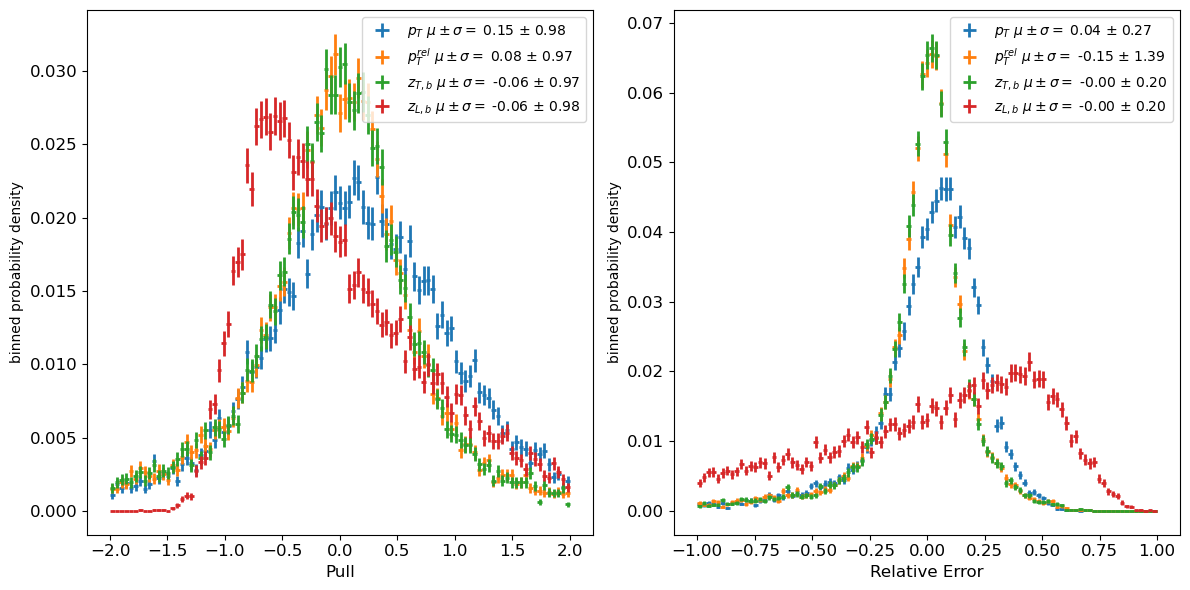

In [78]:
fig, axes = plt.subplots(1,2, figsize = (12,6))
binneddensitysub(pull[:,3], fixedbinning(-2,2, 100), ax=axes[0], label = r"$p_T$ $\mu \pm \sigma =$ {:.2f} $\pm$ {:.2f}".format(numpy.mean(pull[:,3]), numpy.std(pull[:,3])), xlabel = "Pull")
binneddensitysub(pull[:,-3], fixedbinning(-2,2, 100), ax=axes[0], label = r'$p_T^{rel}$ ' + r"$\mu \pm \sigma =$ {:.2f} $\pm$ {:.2f}".format(numpy.mean(pull[:,-1]), numpy.std(pull[:,-1])))
binneddensitysub(pull[:,-2], fixedbinning(-2,2, 100), ax=axes[0], label = r'$z_{T,b}$ '+  r"$\mu \pm \sigma =$ {:.2f} $\pm$ {:.2f}".format(numpy.mean(pull[:,-2]), numpy.std(pull[:,-2])))
binneddensitysub(pull[:,-1], fixedbinning(-2,2, 100), ax=axes[0], label = r"$z_{L,b}$ "  + r"$\mu \pm \sigma =$ {:.2f} $\pm$ {:.2f}".format(numpy.mean(pull[:,-3]), numpy.std(pull[:,-3]), xlabel = "Pull"))

binneddensitysub(percDiff[:,3], fixedbinning(-1,1, 100), ax=axes[1], label = r"$p_T$ $\mu \pm \sigma =$ {:.2f} $\pm$ {:.2f}".format(numpy.median(percDiff[:,3]), numpy.quantile(percDiff[:,3], 0.75)-numpy.quantile(percDiff[:,3],0.25)), xlabel = "Pull")
binneddensitysub(percDiff[:,-3], fixedbinning(-1,1, 100), ax=axes[1], label = r'$p_T^{rel}$ ' + r"$\mu \pm \sigma =$ {:.2f} $\pm$ {:.2f}".format(numpy.median(percDiff[:,-1]), numpy.quantile(percDiff[:,-1], 0.75)-numpy.quantile(percDiff[:,-1],0.25)))
binneddensitysub(percDiff[:,-2], fixedbinning(-1,1, 100), ax=axes[1], label = r'$z_{T,b}$ '+  r"$\mu \pm \sigma =$ {:.2f} $\pm$ {:.2f}".format(numpy.median(percDiff[:,-2]), numpy.quantile(percDiff[:,-2], 0.75)-numpy.quantile(percDiff[:,-2],0.25)))
binneddensitysub(percDiff[:,-1], fixedbinning(-1,1, 100), ax=axes[1], label = r"$z_{L,b}$ "  + r"$\mu \pm \sigma =$ {:.2f} $\pm$ {:.2f}".format(numpy.median(percDiff[:,-3]), numpy.quantile(percDiff[:,-3], 0.75)-numpy.quantile(percDiff[:,-3],0.25), xlabel = "Pull"))
axes[0].legend(loc='upper right')
axes[0].set_xlabel("Pull", fontsize = 'large', loc = 'center')
#axes[0].set_title('a)', y=-0.11, fontsize= 'large', loc='center')

axes[1].legend()
axes[1].set_xlabel("Relative Error", fontsize = 'large', loc = 'center')
#axes[1].set_title('b)', y=-0.11, fontsize= 'large', loc='center')

axes[0].tick_params(axis='both', labelsize='large')
axes[1].tick_params(axis='both', labelsize='large')

plt.tight_layout()
plt.savefig("FDSE.pdf")
plt.show()

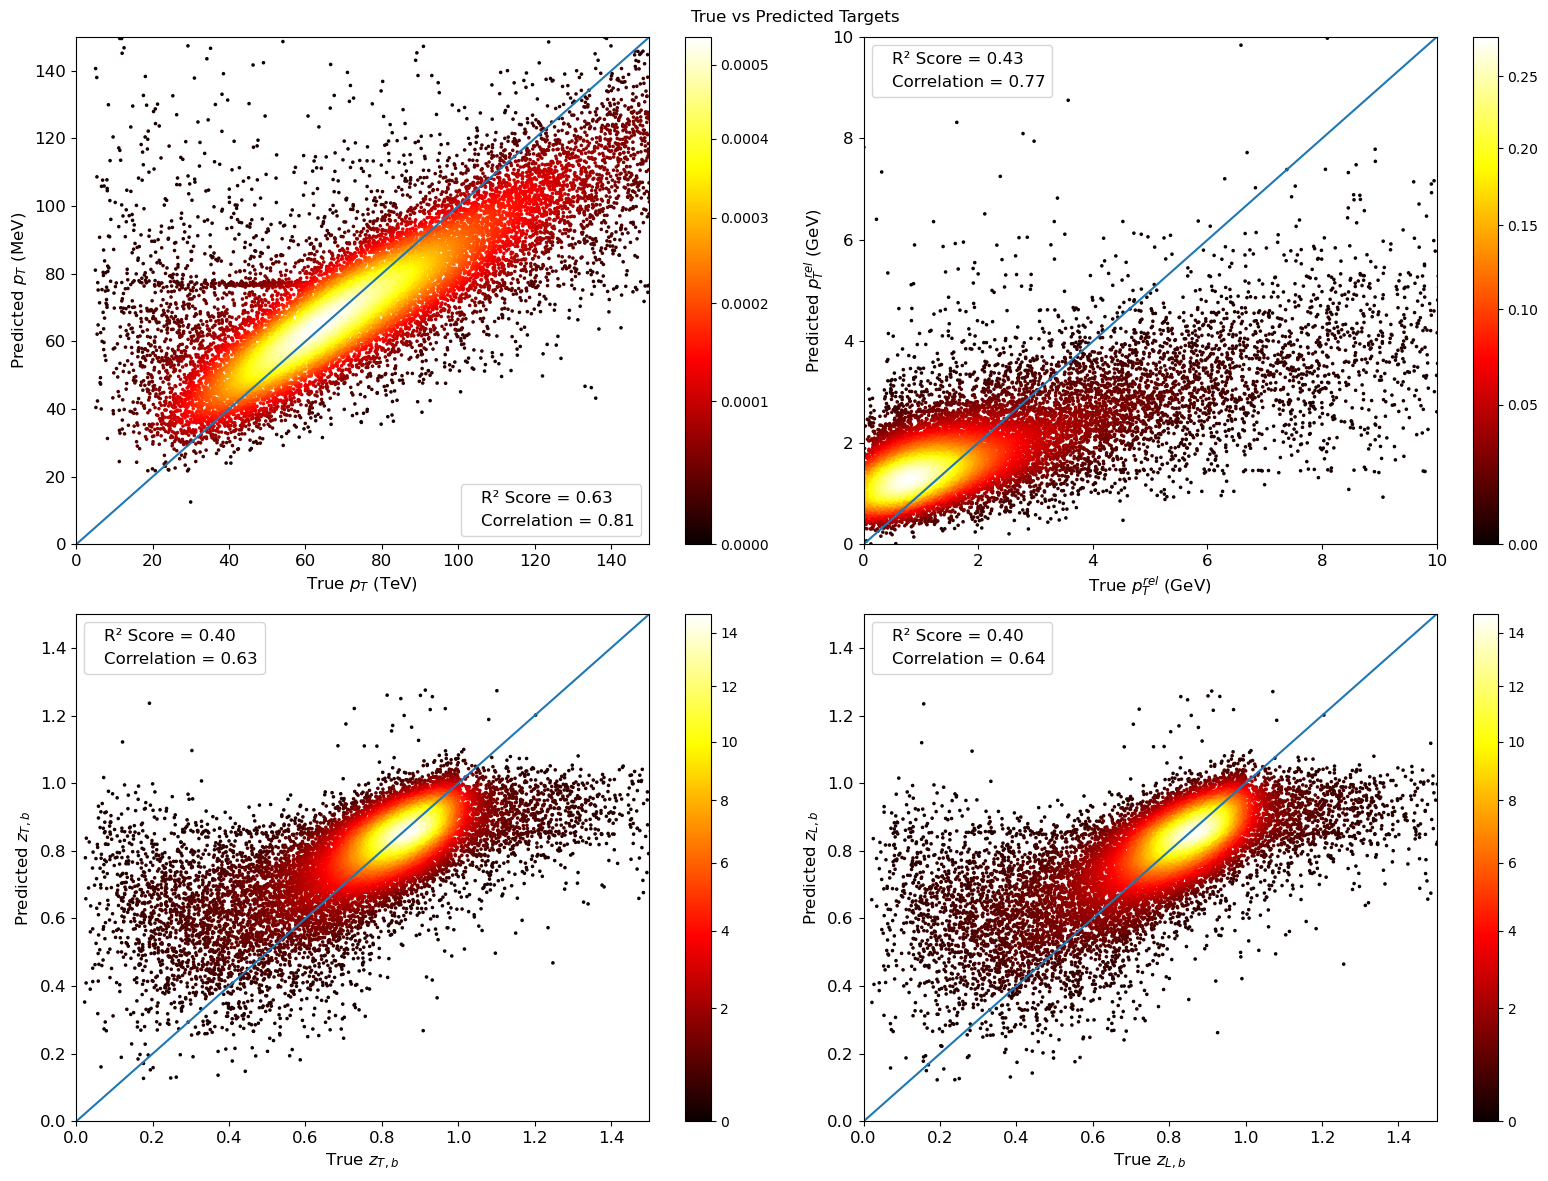

In [89]:
plottingScatter("True vs Predicted Targets")

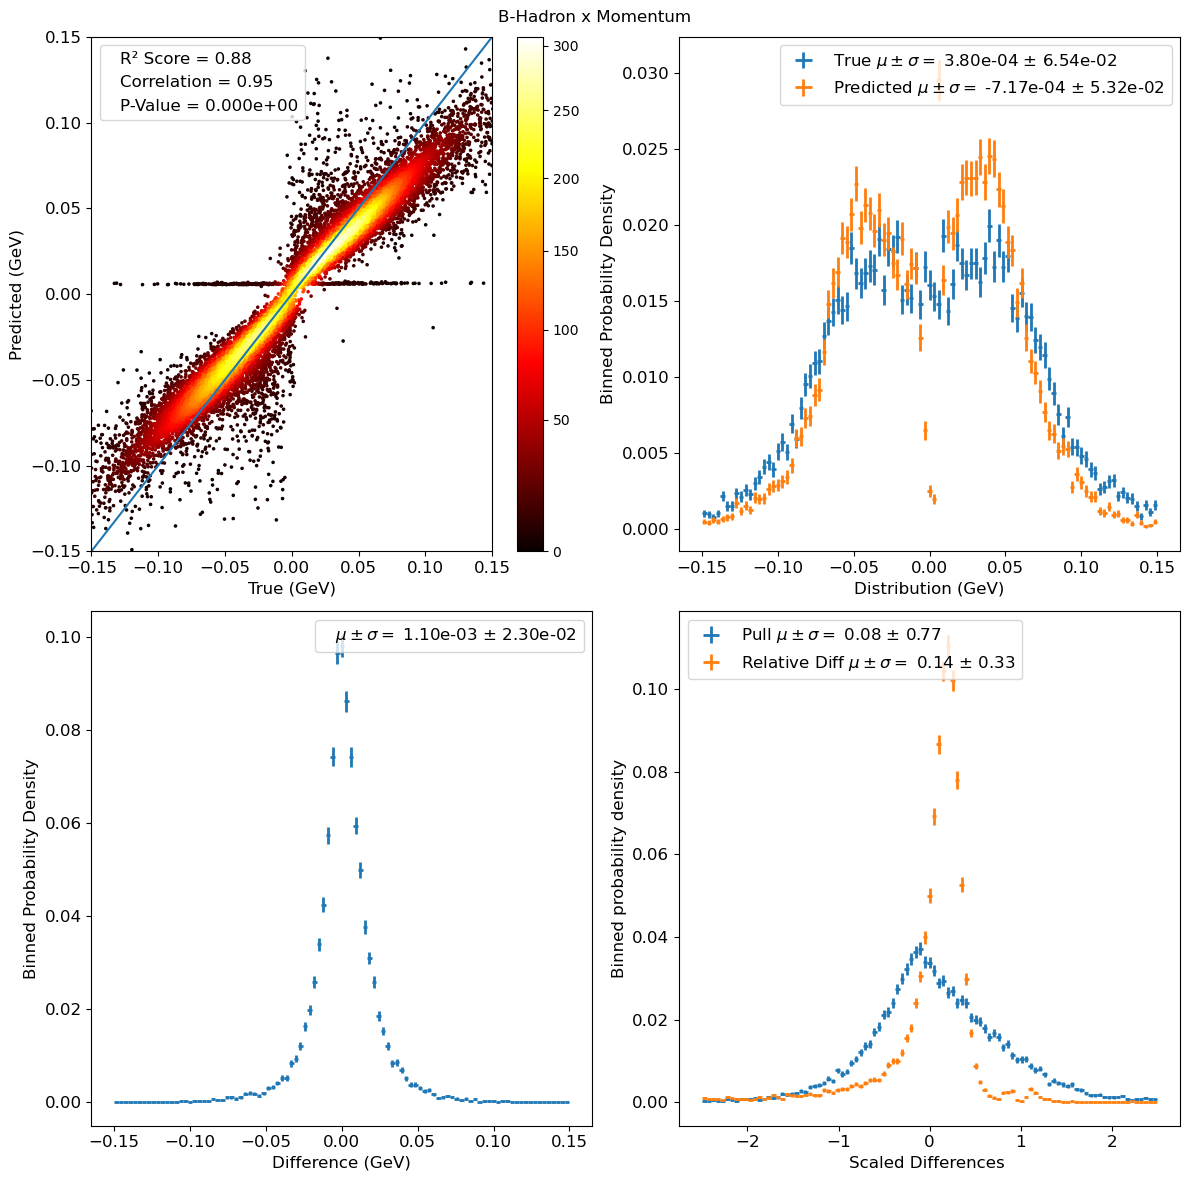

In [83]:
plotting(0, "B-Hadron x Momentum", unit='(GeV)')

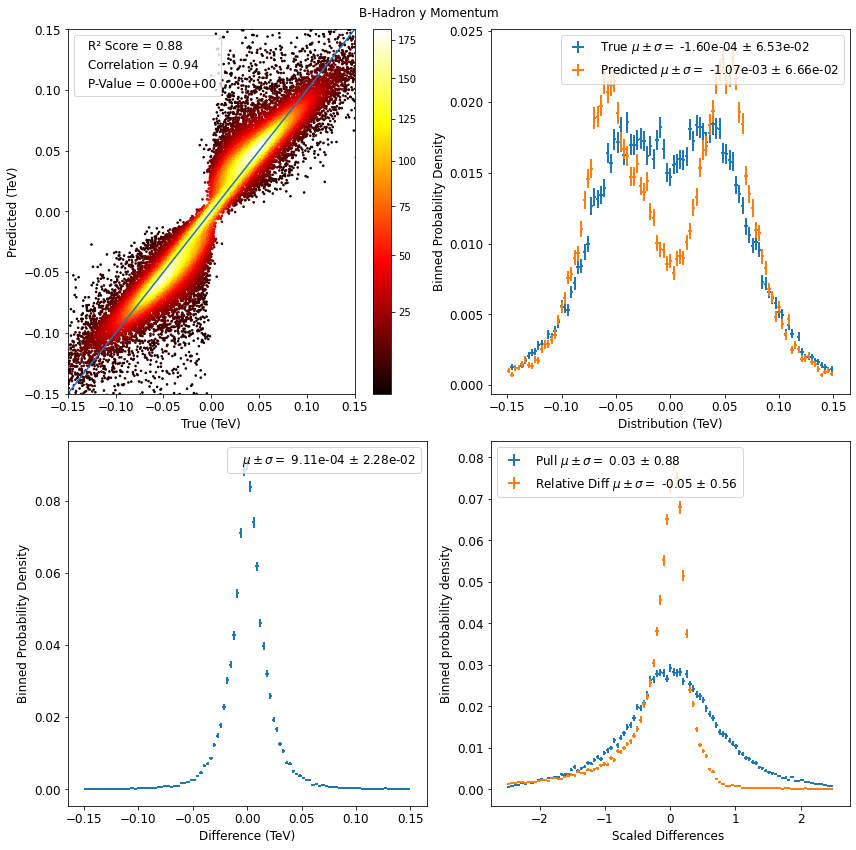

In [58]:
plotting(1, "B-Hadron y Momentum", unit='(TeV)')

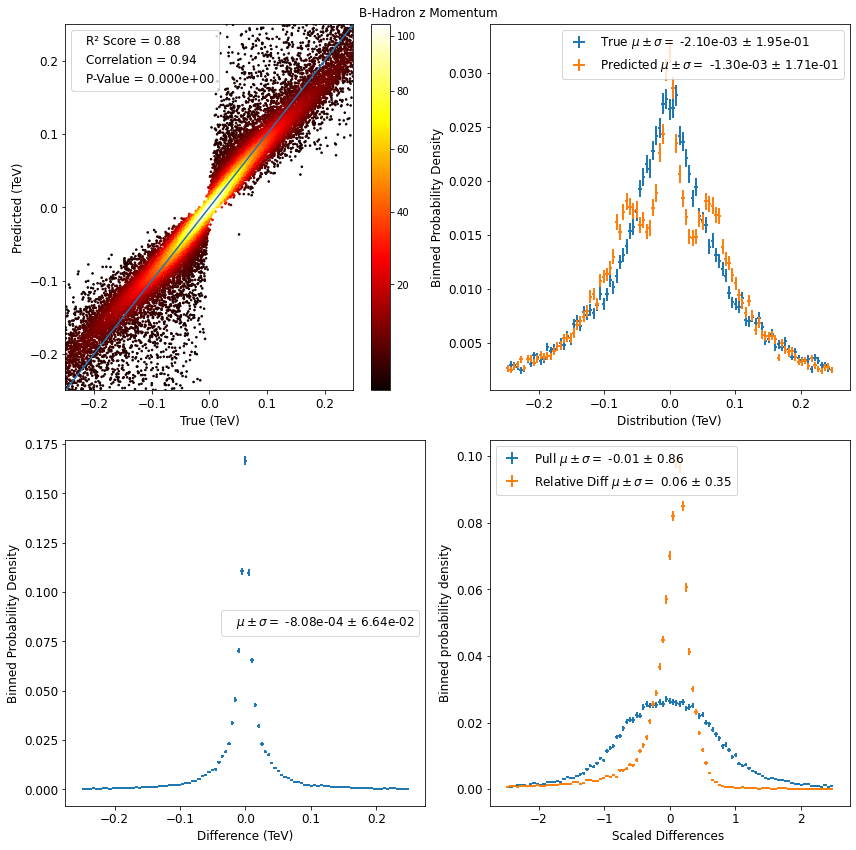

In [59]:
plotting(2, "B-Hadron z Momentum", unit='(TeV)')

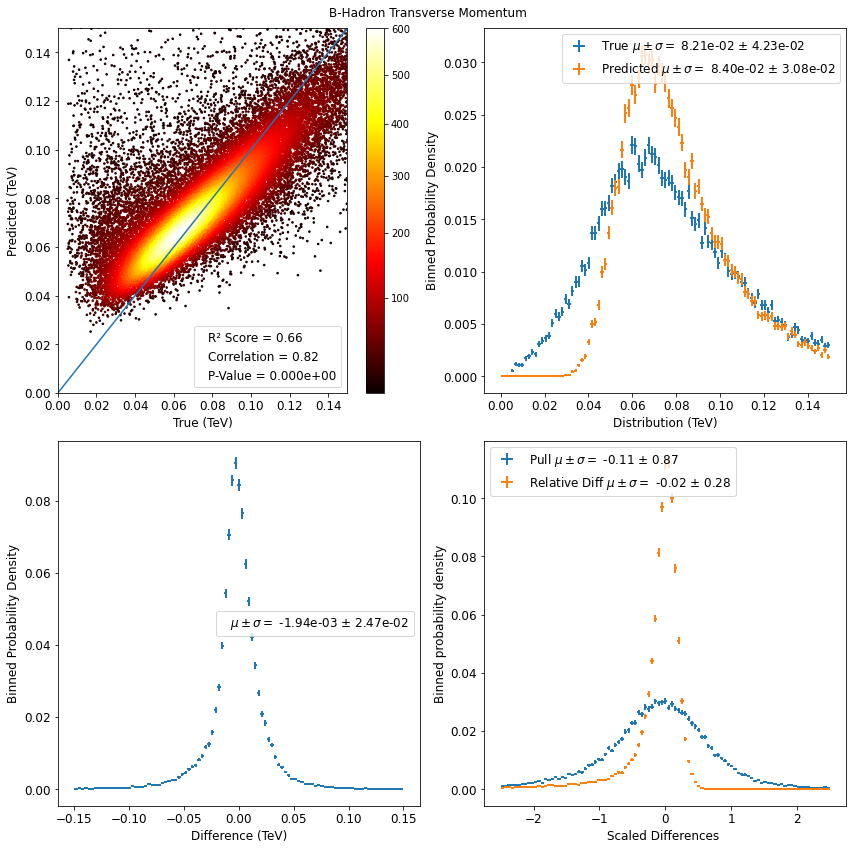

In [60]:
plotting(3, "B-Hadron Transverse Momentum", unit='(TeV)')

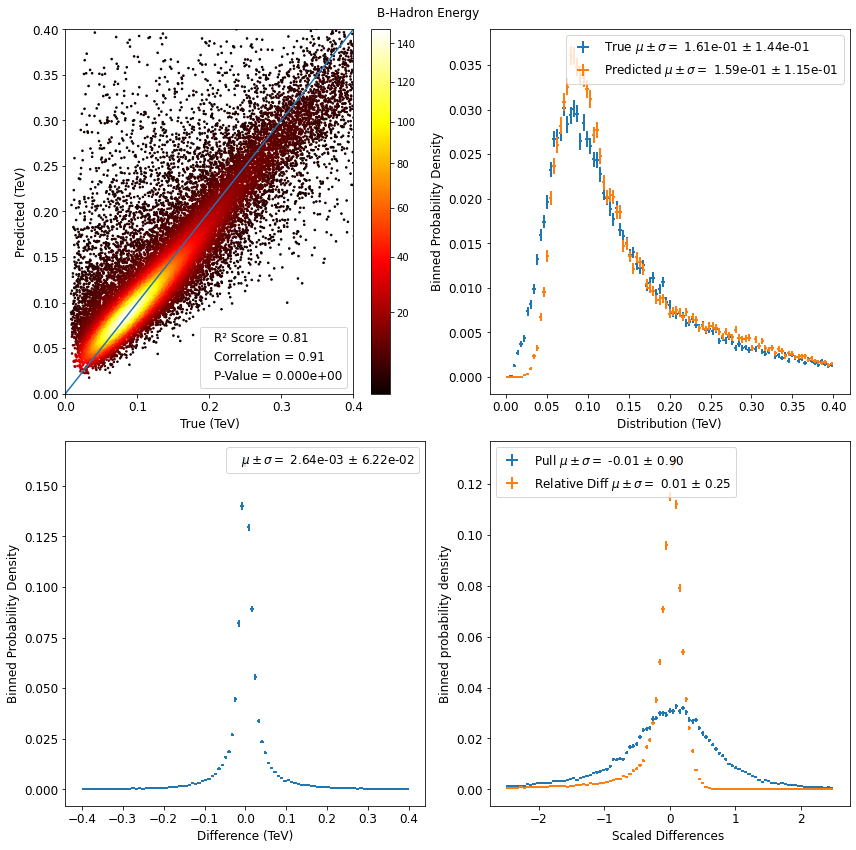

In [61]:
plotting(4, "B-Hadron Energy", unit='(TeV)')

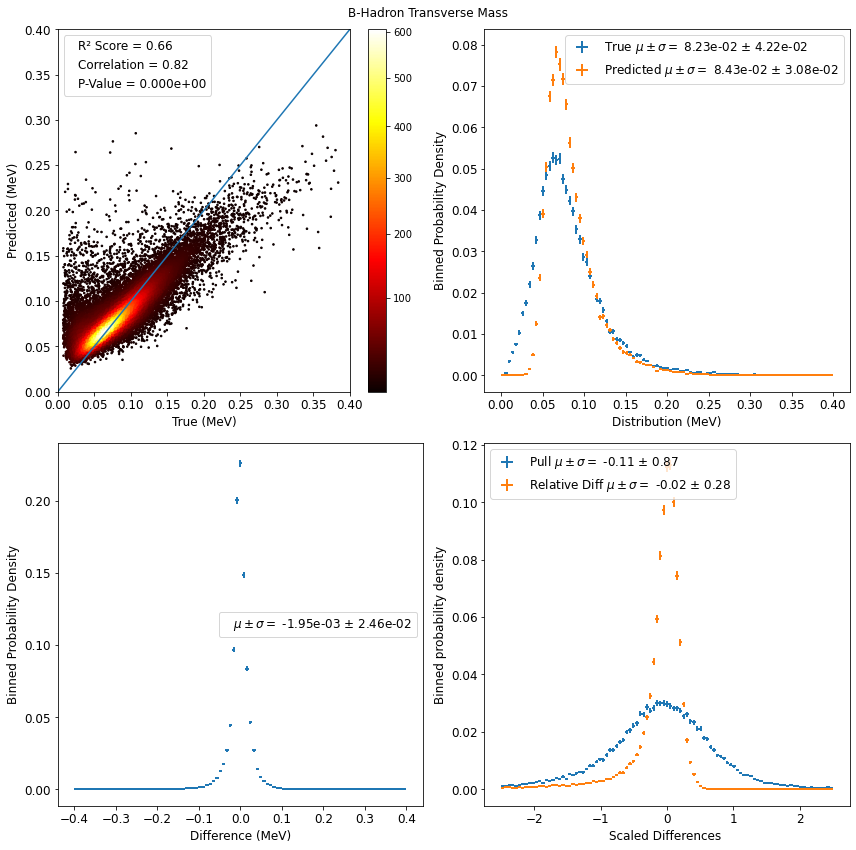

In [62]:
plotting(5, "B-Hadron Transverse Mass", unit='(MeV)')

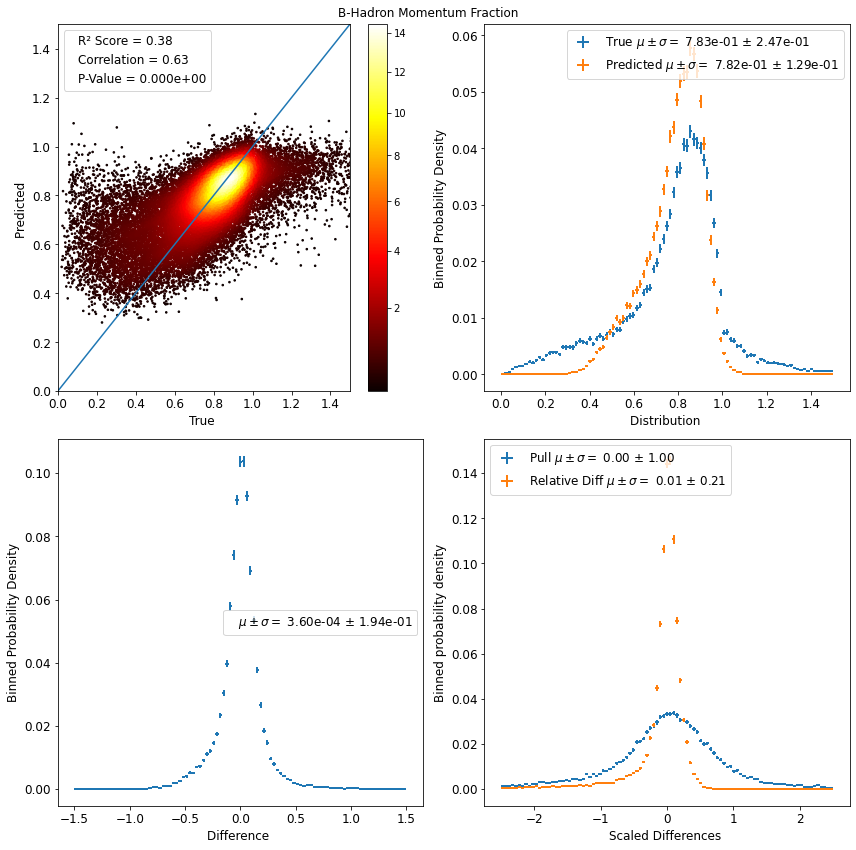

In [63]:
plotting(6, "B-Hadron Momentum Fraction", unit='')

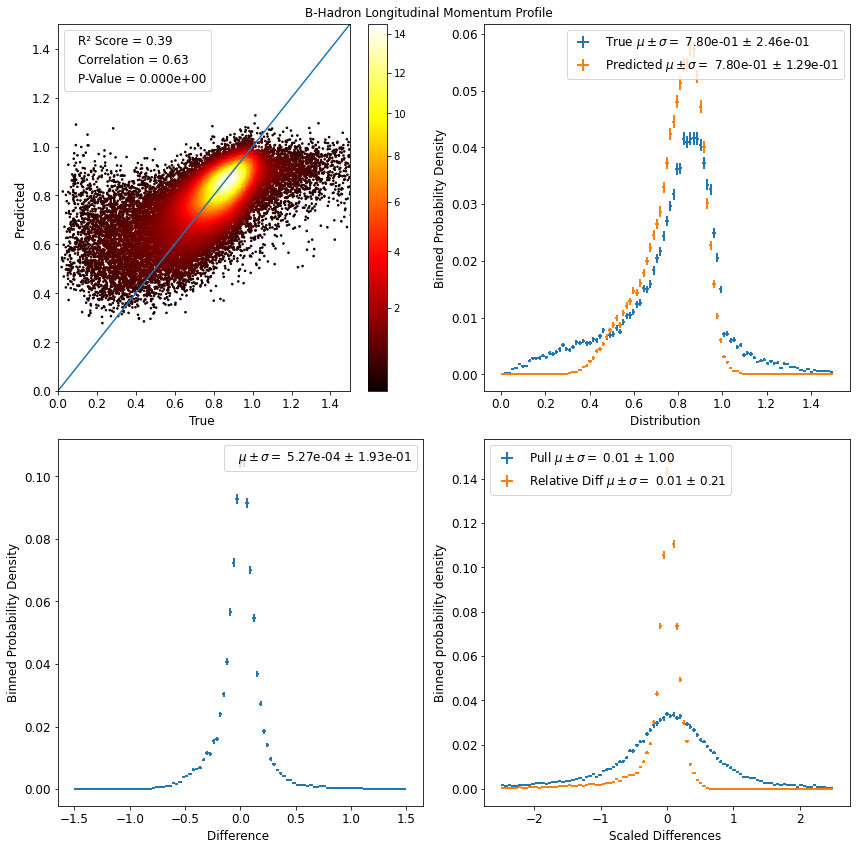

In [64]:
plotting(7, "B-Hadron Longitudinal Momentum Profile", unit='')

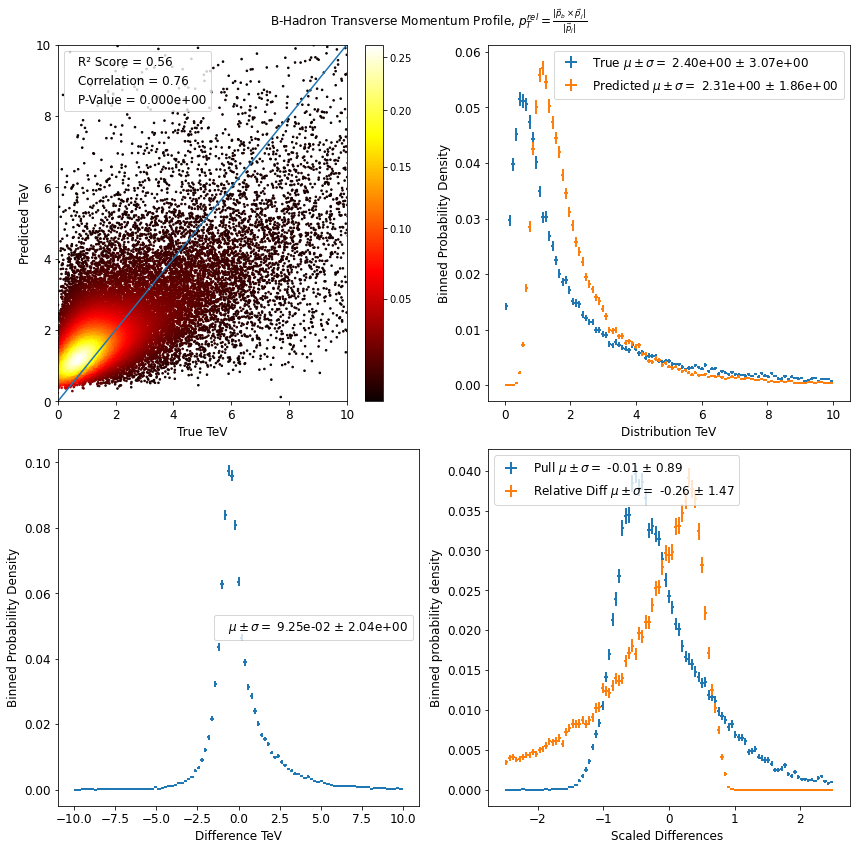

In [65]:
plotting(8, r"B-Hadron Transverse Momentum Profile, $p_T^{rel} = \frac{|\vec{p}_b \times \vec{p}_j|}{|\vec{p}_j|}$", unit="TeV")

In [ ]:
import tensorflow_probability as tfp
covar = tfp.stats.correlation(pred[:50,:])

In [ ]:
print(numpy.shape(covar))
print(covar[0])

In [ ]:
fig, axes = plt.subplots(figsize = (8,6))
im = axes.imshow(covar, cmap = 'hot', origin='lower')
targets = ['', '$p_x$', '$p_y$', '$p_z$', '$p_T$', '${p}$', '$E$', '$Fraction$', '$Projection$', '$m$']
axes.set_xticklabels(targets)
axes.set_yticklabels(targets)
plt.setp(axes.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fig.colorbar(im)
plt.show()